# Design CTP-14, mouse, long-5kb-tracing library

by Pu Zheng

2022.12.12

> Directly use the pb_dict from the previous multiplexed-tracing_design:
>>http://localhost:8889/notebooks/Library_design/CTP-14-human_brain_genome/2.1_Library-design_CTP14_mouse_5kb_multi-tracing_and_sequential.ipynb
>>
> Then re-add sequential tracing probes

In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
from ImageAnalysis3 import library_tools
print(os.getpid())

20896


<a id='0.1'></a>
# 0.1 Folders

In [2]:
## Some folders
# human genome
reference_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\mouse\GRCm38_ensembl'
genome_folder = os.path.join(reference_folder, 'Genome')
# Library directories
pool_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain'
if not os.path.exists(pool_folder):
    print(f"Create pool_folder: {pool_folder}")
    os.makedirs(pool_folder)
else:
    print(f"Use pool_folder: {pool_folder}")

Use pool_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain


In [3]:
# folder for sub-pool
library_folder = os.path.join(pool_folder, f'mouse_long_5kb_sequential')
if not os.path.exists(library_folder):
    print(f"create library folder: {library_folder}")
    os.makedirs(library_folder)
# folder for fasta sequences
sequence_folder = os.path.join(library_folder, 'sequences')
if not os.path.exists(sequence_folder):
    print(f"create sequence folder: {sequence_folder}")
    os.makedirs(sequence_folder)
# folder to save result probes
report_folder = os.path.join(library_folder, 'reports')
if not os.path.exists(report_folder):
    print(f"create report folder: {report_folder}")
    os.makedirs(report_folder)
    
print(f"-- library_folder: {library_folder}")
print(f"-- sequence_folder: {sequence_folder}")
print(f"-- report_folder: {report_folder}")

create library folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential
create sequence folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\sequences
create report folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\reports
-- library_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential
-- sequence_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\sequences
-- report_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\reports


## Load previous pb_dict

In [4]:
original_report_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb\reports'
pb_dict_filename = os.path.join(original_report_folder, 'pb_dict.pkl')

print(f"Loading pb_dict from file: {pb_dict_filename}")
pb_dict = pickle.load(open(pb_dict_filename, 'rb'))

Loading pb_dict from file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb\reports\pb_dict.pkl


## apply filtering

In [5]:
num_probes_kept = 80 # max num of probes kept for each region
filtered_pb_dict = library_tools.quality_check.Screen_probe_by_hit(library_folder, pb_dict, num_probes_kept,
                                                                  hit_type='genome')

## filter by minimum number of probes in each region
min_num_probes = 21
removed_regions = []
for _rid, _pb_class in filtered_pb_dict.items():
    if len(_pb_class.kept_probes) < min_num_probes:
        print(f"region: {_rid} removed with {len(_pb_class.kept_probes)} probes")
        removed_regions.append(_rid)
for _rid in removed_regions:
    del(filtered_pb_dict[_rid])

- Screen probes by genome counts.
-- filtering region:Chr7-6Mb-seg-1, directly append 52 probes
-- filtering region:Chr7-6Mb-seg-2, directly append 60 probes
-- filtering region:Chr7-6Mb-seg-3, directly append 49 probes
-- filtering region:Chr7-6Mb-seg-4, directly append 52 probes
-- filtering region:Chr7-6Mb-seg-5, directly append 18 probes
-- filtering region:Chr7-6Mb-seg-6, directly append 19 probes
-- filtering region:Chr7-6Mb-seg-7, directly append 30 probes
-- filtering region:Chr7-6Mb-seg-8, directly append 6 probes
-- filtering region:Chr7-6Mb-seg-9, directly append 60 probes
-- filtering region:Chr7-6Mb-seg-10, directly append 41 probes
-- filtering region:Chr7-6Mb-seg-11, directly append 44 probes
-- filtering region:Chr7-6Mb-seg-12, directly append 40 probes
-- filtering region:Chr7-6Mb-seg-13, directly append 20 probes
-- filtering region:Chr7-6Mb-seg-14, directly append 26 probes
-- filtering region:Chr7-6Mb-seg-15, directly append 66 probes
-- filtering region:Chr7-6Mb-se

In [6]:
len(pb_dict), len(filtered_pb_dict)

(1191, 1097)

<IPython.core.display.Javascript object>


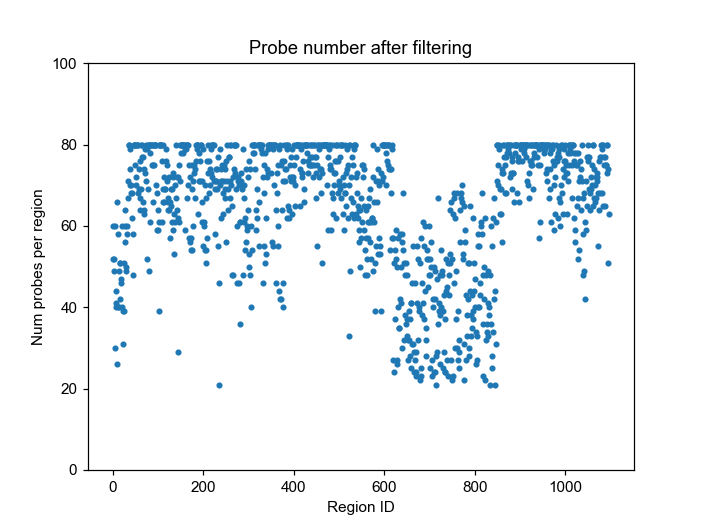

In [7]:
pb_num_dict = {_k:len(_v.kept_probes) for _k,_v in filtered_pb_dict.items()}

pb_nums = np.array(list(pb_num_dict.values()))
# number of probes histogram
fig, ax = plt.subplots()
ax.plot(pb_nums, '.')
ax.set_ylabel("Num probes per region")
ax.set_xlabel("Region ID")
ax.set_title("Probe number after filtering")
ax.set_ylim([0,100])
plt.show()

In [8]:
chr_2_region_savefile = os.path.join(library_folder, 'chr_2_final_region_num.pkl')
overwrite = True

filtered_reg_names = {}
for _reg, _pbde in filtered_pb_dict.items():
    if len(_pbde.kept_probes) > 0:
        filtered_reg_names[_reg] = list(_pbde.kept_probes.values())[0]['reg_name']

if not os.path.exists(chr_2_region_savefile) or overwrite:
    chr_2_region_num = {}
    for _reg, _info in filtered_reg_names.items():
        _chr = _info.split('_')[0].split(':')[0]
        if _chr not in chr_2_region_num:
            chr_2_region_num[_chr] = 1
        else:
            chr_2_region_num[_chr] += 1
    print(f"Saving into file: {chr_2_region_savefile}")

    pickle.dump(chr_2_region_num, open(chr_2_region_savefile, 'wb'))
else:
    print(f"loading from file: {chr_2_region_savefile}")
    chr_2_region_num = pickle.load(open(chr_2_region_savefile, 'rb'))

Saving into file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\chr_2_final_region_num.pkl


In [9]:
chr_2_region_num

{'7': 1097}

In [10]:
# 
reg_2_start = {}

for _name, _info in filtered_reg_names.items():
    _locus = _info.split('_')[0]
    _start,_end = _locus.split(':')[1].split('-')
    reg_2_start[_name] = int(_start)
#    
chr_2_region_names = {}

for _reg, _info in filtered_reg_names.items():
    _chr = _info.split('_')[0].split(':')[0]
    if _chr not in chr_2_region_names:
        chr_2_region_names[_chr] = [_reg]
    else:
        chr_2_region_names[_chr].append(_reg)
# sort
for _chr, _regs in chr_2_region_names.items():
    _sorted_regs = sorted(_regs, key=lambda _r: reg_2_start[_r])
    chr_2_region_names[_chr] = _sorted_regs
    
overwrite_region_names = True
chr_2_region_name_savefile = os.path.join(library_folder, 'chr_2_region_names.pkl')

if not os.path.exists(chr_2_region_name_savefile) or overwrite_region_names:
    print(f"Saving region names into file: {chr_2_region_name_savefile}")
    pickle.dump(chr_2_region_names, open(chr_2_region_name_savefile, 'wb'))

Saving region names into file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\chr_2_region_names.pkl


<a id='3'></a>
# 3. Load and asssemble probes

In [12]:
num_readout_per_probe = 4
primer_len=20
target_len=42
min_num_probes = 21
# merfish related
num_on_bits = 3

## 3.1 generate sequential encoding

In [13]:
sequential_region_2_readout_dict = {}
for _i, _reg in enumerate(filtered_pb_dict):
    sequential_region_2_readout_dict[_reg] = [f"u{_i}"] * num_readout_per_probe
print(sequential_region_2_readout_dict)

{'Chr7-6Mb-seg-1': ['u0', 'u0', 'u0', 'u0'], 'Chr7-6Mb-seg-2': ['u1', 'u1', 'u1', 'u1'], 'Chr7-6Mb-seg-3': ['u2', 'u2', 'u2', 'u2'], 'Chr7-6Mb-seg-4': ['u3', 'u3', 'u3', 'u3'], 'Chr7-6Mb-seg-7': ['u4', 'u4', 'u4', 'u4'], 'Chr7-6Mb-seg-9': ['u5', 'u5', 'u5', 'u5'], 'Chr7-6Mb-seg-10': ['u6', 'u6', 'u6', 'u6'], 'Chr7-6Mb-seg-11': ['u7', 'u7', 'u7', 'u7'], 'Chr7-6Mb-seg-12': ['u8', 'u8', 'u8', 'u8'], 'Chr7-6Mb-seg-14': ['u9', 'u9', 'u9', 'u9'], 'Chr7-6Mb-seg-15': ['u10', 'u10', 'u10', 'u10'], 'Chr7-6Mb-seg-16': ['u11', 'u11', 'u11', 'u11'], 'Chr7-6Mb-seg-19': ['u12', 'u12', 'u12', 'u12'], 'Chr7-6Mb-seg-20': ['u13', 'u13', 'u13', 'u13'], 'Chr7-6Mb-seg-21': ['u14', 'u14', 'u14', 'u14'], 'Chr7-6Mb-seg-22': ['u15', 'u15', 'u15', 'u15'], 'Chr7-6Mb-seg-23': ['u16', 'u16', 'u16', 'u16'], 'Chr7-6Mb-seg-24': ['u17', 'u17', 'u17', 'u17'], 'Chr7-6Mb-seg-25': ['u18', 'u18', 'u18', 'u18'], 'Chr7-6Mb-seg-27': ['u19', 'u19', 'u19', 'u19'], 'Chr7-6Mb-seg-28': ['u20', 'u20', 'u20', 'u20'], 'Chr7-6Mb-seg-29

## 3.2 primers

8,7

In [28]:
from ImageAnalysis3 import library_tools
primer_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Primers'
primers = library_tools.assemble.load_primers([8,7], _primer_folder=primer_folder)

- Picked primer: ID: W1A09_primer_8
Name: W1A09_primer_8
Description: W1A09_primer_8
Number of features: 0
Seq('TTGTTGAGGCGGCGGAAGTC')
- Picked primer: ID: W1A08_primer_7
Name: W1A08_primer_7
Description: W1A08_primer_7
Number of features: 0
Seq('TAATACGACTCACTATAGGGCCCTTTCGCGCTGCATCGAC')


## 3.3 readouts

In [14]:
# collect types from region_2_readout_dict
sequential_readout_usage_by_type = {}
for _region, _infos in sequential_region_2_readout_dict.items():
    for _info in _infos:
        if _info[0] not in sequential_readout_usage_by_type:
            sequential_readout_usage_by_type[_info[0]] = []
        if int(_info[1:]) not in sequential_readout_usage_by_type[_info[0]]:
            sequential_readout_usage_by_type[_info[0]].append(int(_info[1:]))

readout_usage_dict = {_type:len(_v) for _type,_v in sequential_readout_usage_by_type.items()}

# collect types from region_2_readout_dict
sequential_readout_usage_dict = {}
for _region, _infos in sequential_region_2_readout_dict.items():
    for _info in _infos:
        if _info[0] not in sequential_readout_usage_by_type:
            sequential_readout_usage_by_type[_info[0]] = []
        if int(_info[1:]) not in sequential_readout_usage_by_type[_info[0]]:
            sequential_readout_usage_by_type[_info[0]].append(int(_info[1:]))

sequential_readout_usage_dict = {_type:len(_v) for _type,_v in sequential_readout_usage_by_type.items()}
sequential_readout_usage_dict

{'u': 1097}

In [23]:
from ImageAnalysis3.classes import _allowed_kwds

sequential_readout_dict ={}
overwrite_readout_usage = True
readout_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Readouts'

# unique
readout_type = 'unique'
# 
_type_char = _allowed_kwds[readout_type]
_readout_start = 0
_num_color = 3

sequential_readout_dict[_type_char] = library_tools.assemble.load_readouts(
    readout_usage_dict[_type_char], 
    _type='designed_readouts', 
    _readout_folder=readout_folder, 
    _num_colors=_num_color, # 750,647,561
    _start_id=_readout_start,
    )

\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Readouts\designed_readouts_750.fasta 453 0 366
\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Readouts\designed_readouts_647.fasta 453 0 366
\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Readouts\designed_readouts_561.fasta 452 0 366
[366, 366, 366]


In [24]:
print([_r.id for _r in sequential_readout_dict['u']])

['Stv_3', 'Stv_32', 'Stv_91', 'Stv_4', 'Stv_33', 'Stv_92', 'Stv_5', 'Stv_35', 'Stv_94', 'Stv_6', 'Stv_36', 'Stv_95', 'Stv_7', 'Stv_37', 'Stv_99', 'Stv_8', 'Stv_39', 'Stv_100', 'Stv_9', 'Stv_40', 'Stv_101', 'Stv_10', 'Stv_42', 'Stv_104', 'Stv_11', 'Stv_44', 'Stv_105', 'Stv_12', 'Stv_45', 'Stv_106', 'Stv_13', 'Stv_46', 'Stv_107', 'Stv_14', 'Stv_48', 'Stv_109', 'Stv_16', 'Stv_50', 'Stv_118', 'Stv_19', 'Stv_53', 'Stv_119', 'Stv_20', 'Stv_54', 'Stv_120', 'Stv_21', 'Stv_59', 'Stv_121', 'Stv_22', 'Stv_60', 'Stv_125', 'Stv_23', 'Stv_61', 'Stv_127', 'Stv_25', 'Stv_63', 'Stv_129', 'Stv_26', 'Stv_64', 'Stv_130', 'Stv_27', 'Stv_65', 'Stv_131', 'Stv_28', 'Stv_86', 'Stv_133', 'Stv_29', 'Stv_87', 'Stv_136', 'Stv_30', 'Stv_88', 'Stv_145', 'Stv_31', 'Stv_90', 'Stv_182', 'NDB_1', 'NDB_2', 'NDB_3', 'NDB_4', 'NDB_5', 'NDB_6', 'NDB_7', 'NDB_8', 'NDB_9', 'NDB_10', 'NDB_11', 'NDB_12', 'NDB_13', 'NDB_14', 'NDB_15', 'NDB_16', 'NDB_17', 'NDB_18', 'NDB_19', 'NDB_20', 'NDB_21', 'NDB_22', 'NDB_23', 'NDB_24', 'NDB_

In [25]:
# save
sequential_readout_usage_file = os.path.join(library_folder, 'sequential_readout_usage.pkl')
if not os.path.isfile(sequential_readout_usage_file) or overwrite_readout_usage:
    print('save sequential readout usage dict')
    pickle.dump(sequential_readout_dict, open(sequential_readout_usage_file, 'wb'))

save sequential readout usage dict


## 3.3 Rerun assemble probes

In [26]:
reload(library_tools.assemble)
from ImageAnalysis3.library_tools.assemble import Assemble_probes

# params
assemble_params = {
    'primer_len':20,
    'num_readout_per_probe':4, 
}

In [29]:
# run assembly

cand_sequential_probes, readout_summary = Assemble_probes(
    library_folder, filtered_pb_dict, 
    sequential_region_2_readout_dict, sequential_readout_dict, primers, 
    primer_len=assemble_params['primer_len'], 
    num_readout_per_probe=assemble_params['num_readout_per_probe'], 
    unique_readout_per_probe=True,
    #save_folder=sequential_assemble_folder,
    rc_targets=False, overwrite=False)

- Assemble probes by given target sequences, readouts and primers.
-- included readout types: ['u']
--- assemblying 52 probes in region: Chr7-6Mb-seg-1
--- assemblying 60 probes in region: Chr7-6Mb-seg-2
--- assemblying 49 probes in region: Chr7-6Mb-seg-3
--- assemblying 52 probes in region: Chr7-6Mb-seg-4
--- assemblying 30 probes in region: Chr7-6Mb-seg-7
--- assemblying 60 probes in region: Chr7-6Mb-seg-9
--- assemblying 41 probes in region: Chr7-6Mb-seg-10
--- assemblying 44 probes in region: Chr7-6Mb-seg-11
--- assemblying 40 probes in region: Chr7-6Mb-seg-12
--- assemblying 26 probes in region: Chr7-6Mb-seg-14
--- assemblying 66 probes in region: Chr7-6Mb-seg-15
--- assemblying 58 probes in region: Chr7-6Mb-seg-16
--- assemblying 40 probes in region: Chr7-6Mb-seg-19
--- assemblying 49 probes in region: Chr7-6Mb-seg-20
--- assemblying 40 probes in region: Chr7-6Mb-seg-21
--- assemblying 51 probes in region: Chr7-6Mb-seg-22
--- assemblying 42 probes in region: Chr7-6Mb-seg-23
--- a

--- assemblying 80 probes in region: Chr7-6Mb-seg-174
--- assemblying 59 probes in region: Chr7-6Mb-seg-175
--- assemblying 79 probes in region: Chr7-6Mb-seg-176
--- assemblying 79 probes in region: Chr7-6Mb-seg-177
--- assemblying 80 probes in region: Chr7-6Mb-seg-178
--- assemblying 67 probes in region: Chr7-6Mb-seg-179
--- assemblying 80 probes in region: Chr7-6Mb-seg-180
--- assemblying 80 probes in region: Chr7-6Mb-seg-181
--- assemblying 80 probes in region: Chr7-6Mb-seg-182
--- assemblying 70 probes in region: Chr7-6Mb-seg-183
--- assemblying 75 probes in region: Chr7-6Mb-seg-184
--- assemblying 57 probes in region: Chr7-6Mb-seg-185
--- assemblying 72 probes in region: Chr7-6Mb-seg-186
--- assemblying 56 probes in region: Chr7-6Mb-seg-187
--- assemblying 54 probes in region: Chr7-6Mb-seg-188
--- assemblying 57 probes in region: Chr7-6Mb-seg-189
--- assemblying 54 probes in region: Chr7-6Mb-seg-190
--- assemblying 69 probes in region: Chr7-6Mb-seg-191
--- assemblying 75 probes in

--- assemblying 80 probes in region: Chr7-6Mb-seg-329
--- assemblying 80 probes in region: Chr7-6Mb-seg-330
--- assemblying 74 probes in region: Chr7-6Mb-seg-331
--- assemblying 59 probes in region: Chr7-6Mb-seg-332
--- assemblying 64 probes in region: Chr7-6Mb-seg-333
--- assemblying 69 probes in region: Chr7-6Mb-seg-334
--- assemblying 62 probes in region: Chr7-6Mb-seg-335
--- assemblying 80 probes in region: Chr7-6Mb-seg-336
--- assemblying 80 probes in region: Chr7-6Mb-seg-337
--- assemblying 66 probes in region: Chr7-6Mb-seg-338
--- assemblying 80 probes in region: Chr7-6Mb-seg-339
--- assemblying 55 probes in region: Chr7-6Mb-seg-340
--- assemblying 80 probes in region: Chr7-6Mb-seg-341
--- assemblying 80 probes in region: Chr7-6Mb-seg-342
--- assemblying 79 probes in region: Chr7-6Mb-seg-343
--- assemblying 80 probes in region: Chr7-6Mb-seg-344
--- assemblying 80 probes in region: Chr7-6Mb-seg-345
--- assemblying 78 probes in region: Chr7-6Mb-seg-346
--- assemblying 72 probes in

--- assemblying 80 probes in region: Chr7-6Mb-seg-489
--- assemblying 70 probes in region: Chr7-6Mb-seg-490
--- assemblying 59 probes in region: Chr7-6Mb-seg-491
--- assemblying 77 probes in region: Chr7-6Mb-seg-492
--- assemblying 79 probes in region: Chr7-6Mb-seg-493
--- assemblying 80 probes in region: Chr7-6Mb-seg-494
--- assemblying 75 probes in region: Chr7-6Mb-seg-495
--- assemblying 80 probes in region: Chr7-6Mb-seg-496
--- assemblying 74 probes in region: Chr7-6Mb-seg-497
--- assemblying 59 probes in region: Chr7-6Mb-seg-498
--- assemblying 74 probes in region: Chr7-6Mb-seg-499
--- assemblying 68 probes in region: Chr7-6Mb-seg-500
--- assemblying 80 probes in region: Chr7-6Mb-seg-501
--- assemblying 67 probes in region: Chr7-6Mb-seg-502
--- assemblying 63 probes in region: Chr7-6Mb-seg-503
--- assemblying 73 probes in region: Chr7-6Mb-seg-504
--- assemblying 70 probes in region: Chr7-6Mb-seg-505
--- assemblying 73 probes in region: Chr7-6Mb-seg-506
--- assemblying 80 probes in

--- assemblying 35 probes in region: Chr7-6Mb-seg-660
--- assemblying 42 probes in region: Chr7-6Mb-seg-661
--- assemblying 58 probes in region: Chr7-6Mb-seg-662
--- assemblying 50 probes in region: Chr7-6Mb-seg-663
--- assemblying 41 probes in region: Chr7-6Mb-seg-664
--- assemblying 30 probes in region: Chr7-6Mb-seg-665
--- assemblying 58 probes in region: Chr7-6Mb-seg-668
--- assemblying 56 probes in region: Chr7-6Mb-seg-669
--- assemblying 68 probes in region: Chr7-6Mb-seg-670
--- assemblying 54 probes in region: Chr7-6Mb-seg-671
--- assemblying 51 probes in region: Chr7-6Mb-seg-672
--- assemblying 32 probes in region: Chr7-6Mb-seg-674
--- assemblying 48 probes in region: Chr7-6Mb-seg-675
--- assemblying 38 probes in region: Chr7-6Mb-seg-676
--- assemblying 36 probes in region: Chr7-6Mb-seg-677
--- assemblying 51 probes in region: Chr7-6Mb-seg-679
--- assemblying 37 probes in region: Chr7-6Mb-seg-680
--- assemblying 33 probes in region: Chr7-6Mb-seg-681
--- assemblying 48 probes in

--- assemblying 33 probes in region: Chr7-6Mb-seg-865
--- assemblying 35 probes in region: Chr7-6Mb-seg-866
--- assemblying 43 probes in region: Chr7-6Mb-seg-868
--- assemblying 37 probes in region: Chr7-6Mb-seg-869
--- assemblying 62 probes in region: Chr7-6Mb-seg-870
--- assemblying 39 probes in region: Chr7-6Mb-seg-873
--- assemblying 51 probes in region: Chr7-6Mb-seg-876
--- assemblying 44 probes in region: Chr7-6Mb-seg-878
--- assemblying 47 probes in region: Chr7-6Mb-seg-879
--- assemblying 40 probes in region: Chr7-6Mb-seg-880
--- assemblying 34 probes in region: Chr7-6Mb-seg-881
--- assemblying 26 probes in region: Chr7-6Mb-seg-883
--- assemblying 33 probes in region: Chr7-6Mb-seg-885
--- assemblying 27 probes in region: Chr7-6Mb-seg-888
--- assemblying 58 probes in region: Chr7-6Mb-seg-889
--- assemblying 55 probes in region: Chr7-6Mb-seg-890
--- assemblying 40 probes in region: Chr7-6Mb-seg-891
--- assemblying 40 probes in region: Chr7-6Mb-seg-892
--- assemblying 55 probes in

--- assemblying 80 probes in region: Chr7-6Mb-seg-1060
--- assemblying 80 probes in region: Chr7-6Mb-seg-1061
--- assemblying 73 probes in region: Chr7-6Mb-seg-1062
--- assemblying 74 probes in region: Chr7-6Mb-seg-1063
--- assemblying 71 probes in region: Chr7-6Mb-seg-1064
--- assemblying 80 probes in region: Chr7-6Mb-seg-1065
--- assemblying 80 probes in region: Chr7-6Mb-seg-1066
--- assemblying 80 probes in region: Chr7-6Mb-seg-1067
--- assemblying 67 probes in region: Chr7-6Mb-seg-1068
--- assemblying 78 probes in region: Chr7-6Mb-seg-1069
--- assemblying 74 probes in region: Chr7-6Mb-seg-1070
--- assemblying 69 probes in region: Chr7-6Mb-seg-1071
--- assemblying 61 probes in region: Chr7-6Mb-seg-1072
--- assemblying 79 probes in region: Chr7-6Mb-seg-1073
--- assemblying 79 probes in region: Chr7-6Mb-seg-1074
--- assemblying 80 probes in region: Chr7-6Mb-seg-1075
--- assemblying 76 probes in region: Chr7-6Mb-seg-1076
--- assemblying 80 probes in region: Chr7-6Mb-seg-1077
--- assemb

# 4.Check quality


## 4.1 Load probes

Checking procedures could restart from here

In [32]:
# folder for this library
# biopython imports
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

# candidate full-length probe filename
candidate_probe_filename = os.path.join(library_folder, 'candidate_probes.fasta')
print(candidate_probe_filename)
# load full probes
full_records = []
with open(candidate_probe_filename, 'r') as handle:
    for record in SeqIO.parse(handle, "fasta"):
        full_records.append(record)

print(f"Total probe loaded: {len(full_records)}")

\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\candidate_probes.fasta
Total probe loaded: 70833


### Manually input the following info to double check!

In [39]:
num_readout_per_probe = 4
primer_len=20
target_len=42
min_num_probes = 21
# merfish related
num_on_bits = 1

### 4.1.1 check primer usage

In [34]:
import ImageAnalysis3.library_tools.quality_check as check
reload(check)
primer_check = check._check_primer_usage(full_records, primers[0], primers[1], primer_len=primer_len)
print(primer_check)

-- Checking primer usage, total probes: 70833
True


### 4.1.2 check region probe number

In [35]:
reload(check)
reg_size_dic, len_check = check._check_region_size(full_records, 
                                                   species_marker = 'gene_',
                                                   min_size=min_num_probes)
print(len_check)

gene: Chr7-6Mb-seg-1 -> 52
gene: Chr7-6Mb-seg-2 -> 60
gene: Chr7-6Mb-seg-3 -> 49
gene: Chr7-6Mb-seg-4 -> 52
gene: Chr7-6Mb-seg-7 -> 30
gene: Chr7-6Mb-seg-9 -> 60
gene: Chr7-6Mb-seg-10 -> 41
gene: Chr7-6Mb-seg-11 -> 44
gene: Chr7-6Mb-seg-12 -> 40
gene: Chr7-6Mb-seg-14 -> 26
gene: Chr7-6Mb-seg-15 -> 66
gene: Chr7-6Mb-seg-16 -> 58
gene: Chr7-6Mb-seg-19 -> 40
gene: Chr7-6Mb-seg-20 -> 49
gene: Chr7-6Mb-seg-21 -> 40
gene: Chr7-6Mb-seg-22 -> 51
gene: Chr7-6Mb-seg-23 -> 42
gene: Chr7-6Mb-seg-24 -> 51
gene: Chr7-6Mb-seg-25 -> 46
gene: Chr7-6Mb-seg-27 -> 47
gene: Chr7-6Mb-seg-28 -> 60
gene: Chr7-6Mb-seg-29 -> 40
gene: Chr7-6Mb-seg-36 -> 31
gene: Chr7-6Mb-seg-38 -> 39
gene: Chr7-6Mb-seg-39 -> 39
gene: Chr7-6Mb-seg-40 -> 51
gene: Chr7-6Mb-seg-41 -> 60
gene: Chr7-6Mb-seg-42 -> 56
gene: Chr7-6Mb-seg-43 -> 64
gene: Chr7-6Mb-seg-44 -> 49
gene: Chr7-6Mb-seg-45 -> 50
gene: Chr7-6Mb-seg-46 -> 60
gene: Chr7-6Mb-seg-47 -> 58
gene: Chr7-6Mb-seg-48 -> 71
gene: Chr7-6Mb-seg-49 -> 67
gene: Chr7-6Mb-seg-50 -> 8

<IPython.core.display.Javascript object>


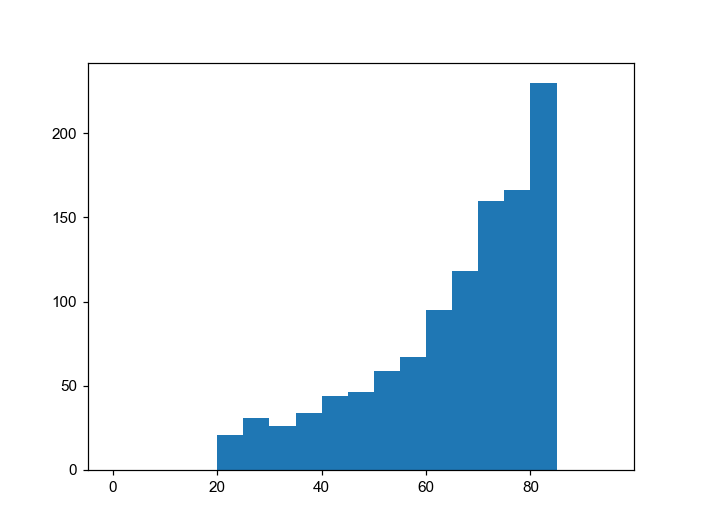

In [36]:
plt.figure()
plt.hist(list(reg_size_dic.values()), bins=np.arange(0,100,5))
plt.show()

### 4.1.3 check readout usage for each gene

In [40]:
reload(check)
check_readout_dict = pickle.load(open(os.path.join(library_folder, 'sequential_readout_usage.pkl'), 'rb'))

reg_readout_dic, reg2readout_check = check._check_region_to_readouts(full_records, check_readout_dict, 
                                                                     total_readout_num=num_on_bits)
print(reg2readout_check)

Chr7-6Mb-seg-1 -> ['Stv_3']
Chr7-6Mb-seg-2 -> ['Stv_32']
Chr7-6Mb-seg-3 -> ['Stv_91']
Chr7-6Mb-seg-4 -> ['Stv_4']
Chr7-6Mb-seg-7 -> ['Stv_33']
Chr7-6Mb-seg-9 -> ['Stv_92']
Chr7-6Mb-seg-10 -> ['Stv_5']
Chr7-6Mb-seg-11 -> ['Stv_35']
Chr7-6Mb-seg-12 -> ['Stv_94']
Chr7-6Mb-seg-14 -> ['Stv_6']
Chr7-6Mb-seg-15 -> ['Stv_36']
Chr7-6Mb-seg-16 -> ['Stv_95']
Chr7-6Mb-seg-19 -> ['Stv_7']
Chr7-6Mb-seg-20 -> ['Stv_37']
Chr7-6Mb-seg-21 -> ['Stv_99']
Chr7-6Mb-seg-22 -> ['Stv_8']
Chr7-6Mb-seg-23 -> ['Stv_39']
Chr7-6Mb-seg-24 -> ['Stv_100']
Chr7-6Mb-seg-25 -> ['Stv_9']
Chr7-6Mb-seg-27 -> ['Stv_40']
Chr7-6Mb-seg-28 -> ['Stv_101']
Chr7-6Mb-seg-29 -> ['Stv_10']
Chr7-6Mb-seg-36 -> ['Stv_42']
Chr7-6Mb-seg-38 -> ['Stv_104']
Chr7-6Mb-seg-39 -> ['Stv_11']
Chr7-6Mb-seg-40 -> ['Stv_44']
Chr7-6Mb-seg-41 -> ['Stv_105']
Chr7-6Mb-seg-42 -> ['Stv_12']
Chr7-6Mb-seg-43 -> ['Stv_45']
Chr7-6Mb-seg-44 -> ['Stv_106']
Chr7-6Mb-seg-45 -> ['Stv_13']
Chr7-6Mb-seg-46 -> ['Stv_46']
Chr7-6Mb-seg-47 -> ['Stv_107']
Chr7-6Mb-seg-48 -

### 4.1.4 check readout usage in the library

In [41]:
reload(check)
readout_reg_dic, readout2reg_check = check._check_readout_to_region(reg_readout_dic, full_records, 
                                                                    check_readout_dict, primer_len=primer_len, 
                                                                    target_len=target_len,
                                                                    probe_readout_num=num_readout_per_probe)
print(readout2reg_check)

-- extracting probes from >region:Chr7-6Mb-seg-1, region:Chr7-6Mb-seg-2, region:Chr7-6Mb-seg-3, region:Chr7-6Mb-seg-4, region:Chr7-6Mb-seg-7, region:Chr7-6Mb-seg-9, region:Chr7-6Mb-seg-10, region:Chr7-6Mb-seg-11, region:Chr7-6Mb-seg-12, region:Chr7-6Mb-seg-14, region:Chr7-6Mb-seg-15, region:Chr7-6Mb-seg-16, region:Chr7-6Mb-seg-19, region:Chr7-6Mb-seg-20, region:Chr7-6Mb-seg-21, region:Chr7-6Mb-seg-22, region:Chr7-6Mb-seg-23, region:Chr7-6Mb-seg-24, region:Chr7-6Mb-seg-25, region:Chr7-6Mb-seg-27, region:Chr7-6Mb-seg-28, region:Chr7-6Mb-seg-29, region:Chr7-6Mb-seg-36, region:Chr7-6Mb-seg-38, region:Chr7-6Mb-seg-39, region:Chr7-6Mb-seg-40, region:Chr7-6Mb-seg-41, region:Chr7-6Mb-seg-42, region:Chr7-6Mb-seg-43, region:Chr7-6Mb-seg-44, region:Chr7-6Mb-seg-45, region:Chr7-6Mb-seg-46, region:Chr7-6Mb-seg-47, region:Chr7-6Mb-seg-48, region:Chr7-6Mb-seg-49, region:Chr7-6Mb-seg-50, region:Chr7-6Mb-seg-51, region:Chr7-6Mb-seg-52, region:Chr7-6Mb-seg-53, region:Chr7-6Mb-seg-54, region:Chr7-6Mb-seg

region:Chr7-6Mb-seg-399, region:Chr7-6Mb-seg-400, region:Chr7-6Mb-seg-401, region:Chr7-6Mb-seg-402, region:Chr7-6Mb-seg-403, region:Chr7-6Mb-seg-404, region:Chr7-6Mb-seg-405, region:Chr7-6Mb-seg-406, region:Chr7-6Mb-seg-407, region:Chr7-6Mb-seg-408, region:Chr7-6Mb-seg-409, region:Chr7-6Mb-seg-410, region:Chr7-6Mb-seg-411, region:Chr7-6Mb-seg-412, region:Chr7-6Mb-seg-413, region:Chr7-6Mb-seg-414, region:Chr7-6Mb-seg-415, region:Chr7-6Mb-seg-416, region:Chr7-6Mb-seg-417, region:Chr7-6Mb-seg-418, region:Chr7-6Mb-seg-419, region:Chr7-6Mb-seg-420, region:Chr7-6Mb-seg-421, region:Chr7-6Mb-seg-422, region:Chr7-6Mb-seg-423, region:Chr7-6Mb-seg-424, region:Chr7-6Mb-seg-425, region:Chr7-6Mb-seg-426, region:Chr7-6Mb-seg-427, region:Chr7-6Mb-seg-428, region:Chr7-6Mb-seg-429, region:Chr7-6Mb-seg-430, region:Chr7-6Mb-seg-431, region:Chr7-6Mb-seg-432, region:Chr7-6Mb-seg-433, region:Chr7-6Mb-seg-434, region:Chr7-6Mb-seg-435, region:Chr7-6Mb-seg-436, region:Chr7-6Mb-seg-437, region:Chr7-6Mb-seg-438, 

region:Chr7-6Mb-seg-786, region:Chr7-6Mb-seg-787, region:Chr7-6Mb-seg-788, region:Chr7-6Mb-seg-790, region:Chr7-6Mb-seg-791, region:Chr7-6Mb-seg-792, region:Chr7-6Mb-seg-793, region:Chr7-6Mb-seg-794, region:Chr7-6Mb-seg-795, region:Chr7-6Mb-seg-796, region:Chr7-6Mb-seg-797, region:Chr7-6Mb-seg-798, region:Chr7-6Mb-seg-799, region:Chr7-6Mb-seg-800, region:Chr7-6Mb-seg-801, region:Chr7-6Mb-seg-802, region:Chr7-6Mb-seg-804, region:Chr7-6Mb-seg-805, region:Chr7-6Mb-seg-806, region:Chr7-6Mb-seg-807, region:Chr7-6Mb-seg-808, region:Chr7-6Mb-seg-809, region:Chr7-6Mb-seg-810, region:Chr7-6Mb-seg-812, region:Chr7-6Mb-seg-813, region:Chr7-6Mb-seg-814, region:Chr7-6Mb-seg-816, region:Chr7-6Mb-seg-817, region:Chr7-6Mb-seg-818, region:Chr7-6Mb-seg-819, region:Chr7-6Mb-seg-820, region:Chr7-6Mb-seg-821, region:Chr7-6Mb-seg-822, region:Chr7-6Mb-seg-823, region:Chr7-6Mb-seg-824, region:Chr7-6Mb-seg-825, region:Chr7-6Mb-seg-828, region:Chr7-6Mb-seg-829, region:Chr7-6Mb-seg-831, region:Chr7-6Mb-seg-832, 

region:Chr7-6Mb-seg-1152, region:Chr7-6Mb-seg-1153, region:Chr7-6Mb-seg-1154, region:Chr7-6Mb-seg-1155, region:Chr7-6Mb-seg-1156, region:Chr7-6Mb-seg-1157, region:Chr7-6Mb-seg-1158, region:Chr7-6Mb-seg-1159, region:Chr7-6Mb-seg-1160, region:Chr7-6Mb-seg-1161, region:Chr7-6Mb-seg-1162, region:Chr7-6Mb-seg-1163, region:Chr7-6Mb-seg-1164, region:Chr7-6Mb-seg-1165, region:Chr7-6Mb-seg-1166, region:Chr7-6Mb-seg-1167, region:Chr7-6Mb-seg-1168, region:Chr7-6Mb-seg-1169, region:Chr7-6Mb-seg-1170, region:Chr7-6Mb-seg-1171, region:Chr7-6Mb-seg-1172, region:Chr7-6Mb-seg-1173, region:Chr7-6Mb-seg-1174, region:Chr7-6Mb-seg-1175, region:Chr7-6Mb-seg-1176, region:Chr7-6Mb-seg-1177, region:Chr7-6Mb-seg-1178, region:Chr7-6Mb-seg-1179, region:Chr7-6Mb-seg-1180, region:Chr7-6Mb-seg-1181, region:Chr7-6Mb-seg-1182, region:Chr7-6Mb-seg-1183, region:Chr7-6Mb-seg-1184, region:Chr7-6Mb-seg-1185, region:Chr7-6Mb-seg-1186, region:Chr7-6Mb-seg-1187, region:Chr7-6Mb-seg-1188, region:Chr7-6Mb-seg-1189, region:Chr7-

### 4.1.5 check bewteen probes

In [42]:
# construct internal map
reload(check)
int_map = check._construct_internal_map(full_records, library_folder, save=False) 

In [44]:
# internal check probes
readout_count_dic, readout_count_check = check._check_readout_in_probes(
    readout_reg_dic, reg_size_dic, int_map, 
    sequential_readout_dict)
print(readout_count_check)

True


In [45]:
# check between probes
kept_records, removed_count = check._check_between_probes(full_records, int_map, 
                                                          primer_len=primer_len, 
                                                          target_len=target_len)

--- Sequence:loc_7:44014999-44019999_gene_Chr7-6Mb-seg-4_pb_5_pos_438_strand_+_readouts_[Stv_4_u,Stv_4_u,Stv_4_u,Stv_4_u]_primers_[W1A09_primer_8,W1A08_primer_7] got hits:53, dumped
--- Sequence:loc_7:44104999-44109999_gene_Chr7-6Mb-seg-22_pb_0_pos_6_strand_+_readouts_[Stv_8_u,Stv_8_u,Stv_8_u,Stv_8_u]_primers_[W1A09_primer_8,W1A08_primer_7] got hits:56, dumped
--- Sequence:loc_7:44189999-44194999_gene_Chr7-6Mb-seg-39_pb_30_pos_3533_strand_+_readouts_[Stv_11_u,Stv_11_u,Stv_11_u,Stv_11_u]_primers_[W1A09_primer_8,W1A08_primer_7] got hits:51, dumped
--- Sequence:loc_7:44209999-44214999_gene_Chr7-6Mb-seg-43_pb_1_pos_252_strand_+_readouts_[Stv_45_u,Stv_45_u,Stv_45_u,Stv_45_u]_primers_[W1A09_primer_8,W1A08_primer_7] got hits:55, dumped
--- Sequence:loc_7:44239999-44244999_gene_Chr7-6Mb-seg-49_pb_6_pos_376_strand_+_readouts_[Stv_48_u,Stv_48_u,Stv_48_u,Stv_48_u]_primers_[W1A09_primer_8,W1A08_primer_7] got hits:57, dumped
--- Sequence:loc_7:44239999-44244999_gene_Chr7-6Mb-seg-49_pb_11_pos_699_st

--- Sequence:loc_7:44859999-44864999_gene_Chr7-6Mb-seg-173_pb_23_pos_1836_strand_+_readouts_[NDB_83_u,NDB_83_u,NDB_83_u,NDB_83_u]_primers_[W1A09_primer_8,W1A08_primer_7] got hits:86, dumped
--- Sequence:loc_7:44859999-44864999_gene_Chr7-6Mb-seg-173_pb_24_pos_1878_strand_+_readouts_[NDB_83_u,NDB_83_u,NDB_83_u,NDB_83_u]_primers_[W1A09_primer_8,W1A08_primer_7] got hits:65, dumped
--- Sequence:loc_7:44859999-44864999_gene_Chr7-6Mb-seg-173_pb_26_pos_1993_strand_-_readouts_[NDB_83_u,NDB_83_u,NDB_83_u,NDB_83_u]_primers_[W1A09_primer_8,W1A08_primer_7] got hits:111, dumped
--- Sequence:loc_7:44859999-44864999_gene_Chr7-6Mb-seg-173_pb_27_pos_2054_strand_+_readouts_[NDB_83_u,NDB_83_u,NDB_83_u,NDB_83_u]_primers_[W1A09_primer_8,W1A08_primer_7] got hits:86, dumped
--- Sequence:loc_7:44859999-44864999_gene_Chr7-6Mb-seg-173_pb_28_pos_2096_strand_+_readouts_[NDB_83_u,NDB_83_u,NDB_83_u,NDB_83_u]_primers_[W1A09_primer_8,W1A08_primer_7] got hits:115, dumped
--- Sequence:loc_7:45004999-45009999_gene_Chr7-6

--- Sequence:loc_7:46179999-46184999_gene_Chr7-6Mb-seg-437_pb_17_pos_1188_strand_+_readouts_[NDB_347_u,NDB_347_u,NDB_347_u,NDB_347_u]_primers_[W1A09_primer_8,W1A08_primer_7] got hits:54, dumped
--- Sequence:loc_7:46319999-46324999_gene_Chr7-6Mb-seg-465_pb_21_pos_1492_strand_+_readouts_[NDB_375_u,NDB_375_u,NDB_375_u,NDB_375_u]_primers_[W1A09_primer_8,W1A08_primer_7] got hits:54, dumped
--- Sequence:loc_7:46579999-46584999_gene_Chr7-6Mb-seg-517_pb_43_pos_2842_strand_+_readouts_[NDB_427_u,NDB_427_u,NDB_427_u,NDB_427_u]_primers_[W1A09_primer_8,W1A08_primer_7] got hits:105, dumped
--- Sequence:loc_7:46594999-46599999_gene_Chr7-6Mb-seg-520_pb_66_pos_4955_strand_+_readouts_[NDB_430_u,NDB_430_u,NDB_430_u,NDB_430_u]_primers_[W1A09_primer_8,W1A08_primer_7] got hits:184, dumped
--- Sequence:loc_7:47269999-47274999_gene_Chr7-6Mb-seg-655_pb_14_pos_1888_strand_+_readouts_[NDB_558_u,NDB_558_u,NDB_558_u,NDB_558_u]_primers_[W1A09_primer_8,W1A08_primer_7] got hits:67, dumped
--- Sequence:loc_7:47319999-

In [46]:
# clear memory
del(int_map)

### 4.1.6 finish checking, save

In [49]:
print(len(kept_records), len(cand_sequential_probes))

70713 70833


In [50]:
# save kept records
with open(os.path.join(library_folder, 'filtered_full_probes.fasta'), 'w') as output_handle:
    SeqIO.write(kept_records, output_handle, "fasta")

## 4.2 BLAST screening of probes

create the local blast database by:
```bash
makeblastdb -in C:\Users\puzheng\Documents\Tools\lowercase_masked\Mus_musculus.GRCm38.dna_sm.merged.fa -dbtype nucl -parse_seqids -out GRCm38_ensembl -title "Mouse chromosomes soft masked" -blastdb_version 4![image.png](attachment:image.png)
```

The outputs are:
```bash
Building a new DB, current time: 03/30/2021 21:49:18
New DB name:   C:\Users\puzheng\Documents\Tools\GRCm38_ensembl
New DB title:  Mouse chromosomes soft masked
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 66 sequences in 42.2668 seconds.
```

In [51]:
import ImageAnalysis3.library_tools.quality_check as check
reload(check)

<module 'ImageAnalysis3.library_tools.quality_check' from 'E:\\Users\\puzheng_new\\Documents\\Chromatin_Analysis_Scripts\\Library_design\\CTP-14-human_brain_genome\\..\\..\\..\\..\\Documents\\ImageAnalysis3\\library_tools\\quality_check.py'>

In [52]:
if 'kept_records' not in locals() or len(kept_records) == 0:
    kept_records = []
    with open(os.path.join(library_folder, 'filtered_full_probes.fasta'), 'r') as handle:
        for record in SeqIO.parse(handle, "fasta"):
            kept_records.append(record)
print(len(kept_records))

70713


In [53]:
blast_database = os.path.join(reference_folder, 'blast_database', 'GRCm38_ensembl')

check.Blast_probes(kept_records, library_folder, num_threads=44, 
                   blast_db=blast_database, blast_evalue=100, overwrite=True)

- Blast probe against \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\mouse\GRCm38_ensembl\blast_database\GRCm38_ensembl
-- number of probes loaded: 70713
-- processing region: Chr7-6Mb-seg-1 with 52 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-1.fasta
--- *blasting region: Chr7-6Mb-seg-1
--- total time for blast Chr7-6Mb-seg-1: 4.936s.
-- processing region: Chr7-6Mb-seg-10 with 41 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-10.fasta
--- *blasting region: Chr7-6Mb-seg-10
--- total time for blast Chr7-6Mb-seg-10: 2.919s.
-- processing region: Chr7-6Mb-seg-100 with 80 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-100.fasta
--- *blasting region: Chr7-6Mb-seg-

--- total time for blast Chr7-6Mb-seg-1021: 3.181s.
-- processing region: Chr7-6Mb-seg-1022 with 70 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-1022.fasta
--- *blasting region: Chr7-6Mb-seg-1022
--- total time for blast Chr7-6Mb-seg-1022: 5.158s.
-- processing region: Chr7-6Mb-seg-1023 with 67 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-1023.fasta
--- *blasting region: Chr7-6Mb-seg-1023
--- total time for blast Chr7-6Mb-seg-1023: 8.618s.
-- processing region: Chr7-6Mb-seg-1024 with 73 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-1024.fasta
--- *blasting region: Chr7-6Mb-seg-1024
--- total time for blast Chr7-6Mb-seg-1024: 4.397s.
-- processing region: Chr7-6Mb-seg-1

--- total time for blast Chr7-6Mb-seg-1046: 6.580s.
-- processing region: Chr7-6Mb-seg-1047 with 75 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-1047.fasta
--- *blasting region: Chr7-6Mb-seg-1047
--- total time for blast Chr7-6Mb-seg-1047: 3.535s.
-- processing region: Chr7-6Mb-seg-1048 with 61 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-1048.fasta
--- *blasting region: Chr7-6Mb-seg-1048
--- total time for blast Chr7-6Mb-seg-1048: 8.218s.
-- processing region: Chr7-6Mb-seg-1049 with 80 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-1049.fasta
--- *blasting region: Chr7-6Mb-seg-1049
--- total time for blast Chr7-6Mb-seg-1049: 3.973s.
-- processing region: Chr7-6Mb-seg-1

--- total time for blast Chr7-6Mb-seg-1070: 3.285s.
-- processing region: Chr7-6Mb-seg-1071 with 69 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-1071.fasta
--- *blasting region: Chr7-6Mb-seg-1071
--- total time for blast Chr7-6Mb-seg-1071: 3.623s.
-- processing region: Chr7-6Mb-seg-1072 with 61 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-1072.fasta
--- *blasting region: Chr7-6Mb-seg-1072
--- total time for blast Chr7-6Mb-seg-1072: 24.654s.
-- processing region: Chr7-6Mb-seg-1073 with 79 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-1073.fasta
--- *blasting region: Chr7-6Mb-seg-1073
--- total time for blast Chr7-6Mb-seg-1073: 6.879s.
-- processing region: Chr7-6Mb-seg-

--- total time for blast Chr7-6Mb-seg-1095: 3.847s.
-- processing region: Chr7-6Mb-seg-1096 with 80 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-1096.fasta
--- *blasting region: Chr7-6Mb-seg-1096
--- total time for blast Chr7-6Mb-seg-1096: 3.927s.
-- processing region: Chr7-6Mb-seg-1097 with 68 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-1097.fasta
--- *blasting region: Chr7-6Mb-seg-1097
--- total time for blast Chr7-6Mb-seg-1097: 6.295s.
-- processing region: Chr7-6Mb-seg-1098 with 63 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-1098.fasta
--- *blasting region: Chr7-6Mb-seg-1098
--- total time for blast Chr7-6Mb-seg-1098: 4.334s.
-- processing region: Chr7-6Mb-seg-1

--- total time for blast Chr7-6Mb-seg-112: 5.386s.
-- processing region: Chr7-6Mb-seg-1120 with 80 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-1120.fasta
--- *blasting region: Chr7-6Mb-seg-1120
--- total time for blast Chr7-6Mb-seg-1120: 4.462s.
-- processing region: Chr7-6Mb-seg-1121 with 80 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-1121.fasta
--- *blasting region: Chr7-6Mb-seg-1121
--- total time for blast Chr7-6Mb-seg-1121: 4.157s.
-- processing region: Chr7-6Mb-seg-1122 with 78 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-1122.fasta
--- *blasting region: Chr7-6Mb-seg-1122
--- total time for blast Chr7-6Mb-seg-1122: 6.334s.
-- processing region: Chr7-6Mb-seg-11

--- total time for blast Chr7-6Mb-seg-1144: 2.809s.
-- processing region: Chr7-6Mb-seg-1145 with 68 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-1145.fasta
--- *blasting region: Chr7-6Mb-seg-1145
--- total time for blast Chr7-6Mb-seg-1145: 3.096s.
-- processing region: Chr7-6Mb-seg-1146 with 49 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-1146.fasta
--- *blasting region: Chr7-6Mb-seg-1146
--- total time for blast Chr7-6Mb-seg-1146: 2.845s.
-- processing region: Chr7-6Mb-seg-1147 with 61 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-1147.fasta
--- *blasting region: Chr7-6Mb-seg-1147
--- total time for blast Chr7-6Mb-seg-1147: 6.672s.
-- processing region: Chr7-6Mb-seg-1

--- total time for blast Chr7-6Mb-seg-1169: 6.120s.
-- processing region: Chr7-6Mb-seg-117 with 61 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-117.fasta
--- *blasting region: Chr7-6Mb-seg-117
--- total time for blast Chr7-6Mb-seg-117: 3.912s.
-- processing region: Chr7-6Mb-seg-1170 with 66 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-1170.fasta
--- *blasting region: Chr7-6Mb-seg-1170
--- total time for blast Chr7-6Mb-seg-1170: 3.979s.
-- processing region: Chr7-6Mb-seg-1171 with 67 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-1171.fasta
--- *blasting region: Chr7-6Mb-seg-1171
--- total time for blast Chr7-6Mb-seg-1171: 5.345s.
-- processing region: Chr7-6Mb-seg-1172 

--- total time for blast Chr7-6Mb-seg-1193: 4.577s.
-- processing region: Chr7-6Mb-seg-1194 with 75 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-1194.fasta
--- *blasting region: Chr7-6Mb-seg-1194
--- total time for blast Chr7-6Mb-seg-1194: 3.955s.
-- processing region: Chr7-6Mb-seg-1195 with 73 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-1195.fasta
--- *blasting region: Chr7-6Mb-seg-1195
--- total time for blast Chr7-6Mb-seg-1195: 3.603s.
-- processing region: Chr7-6Mb-seg-1196 with 80 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-1196.fasta
--- *blasting region: Chr7-6Mb-seg-1196
--- total time for blast Chr7-6Mb-seg-1196: 3.445s.
-- processing region: Chr7-6Mb-seg-1

--- total time for blast Chr7-6Mb-seg-139: 5.012s.
-- processing region: Chr7-6Mb-seg-14 with 26 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-14.fasta
--- *blasting region: Chr7-6Mb-seg-14
--- total time for blast Chr7-6Mb-seg-14: 2.249s.
-- processing region: Chr7-6Mb-seg-140 with 64 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-140.fasta
--- *blasting region: Chr7-6Mb-seg-140
--- total time for blast Chr7-6Mb-seg-140: 4.763s.
-- processing region: Chr7-6Mb-seg-141 with 64 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-141.fasta
--- *blasting region: Chr7-6Mb-seg-141
--- total time for blast Chr7-6Mb-seg-141: 6.121s.
-- processing region: Chr7-6Mb-seg-142 with 57 probes

--- total time for blast Chr7-6Mb-seg-165: 3.509s.
-- processing region: Chr7-6Mb-seg-166 with 80 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-166.fasta
--- *blasting region: Chr7-6Mb-seg-166
--- total time for blast Chr7-6Mb-seg-166: 3.274s.
-- processing region: Chr7-6Mb-seg-167 with 78 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-167.fasta
--- *blasting region: Chr7-6Mb-seg-167
--- total time for blast Chr7-6Mb-seg-167: 6.916s.
-- processing region: Chr7-6Mb-seg-168 with 80 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-168.fasta
--- *blasting region: Chr7-6Mb-seg-168
--- total time for blast Chr7-6Mb-seg-168: 4.232s.
-- processing region: Chr7-6Mb-seg-169 with 80 pr

--- total time for blast Chr7-6Mb-seg-192: 6.955s.
-- processing region: Chr7-6Mb-seg-193 with 71 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-193.fasta
--- *blasting region: Chr7-6Mb-seg-193
--- total time for blast Chr7-6Mb-seg-193: 3.170s.
-- processing region: Chr7-6Mb-seg-194 with 60 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-194.fasta
--- *blasting region: Chr7-6Mb-seg-194
--- total time for blast Chr7-6Mb-seg-194: 3.150s.
-- processing region: Chr7-6Mb-seg-195 with 75 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-195.fasta
--- *blasting region: Chr7-6Mb-seg-195
--- total time for blast Chr7-6Mb-seg-195: 5.616s.
-- processing region: Chr7-6Mb-seg-196 with 73 pr

--- total time for blast Chr7-6Mb-seg-217: 6.174s.
-- processing region: Chr7-6Mb-seg-218 with 60 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-218.fasta
--- *blasting region: Chr7-6Mb-seg-218
--- total time for blast Chr7-6Mb-seg-218: 4.518s.
-- processing region: Chr7-6Mb-seg-219 with 70 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-219.fasta
--- *blasting region: Chr7-6Mb-seg-219
--- total time for blast Chr7-6Mb-seg-219: 4.838s.
-- processing region: Chr7-6Mb-seg-22 with 50 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-22.fasta
--- *blasting region: Chr7-6Mb-seg-22
--- total time for blast Chr7-6Mb-seg-22: 3.572s.
-- processing region: Chr7-6Mb-seg-220 with 54 probes

--- total time for blast Chr7-6Mb-seg-242: 4.801s.
-- processing region: Chr7-6Mb-seg-243 with 71 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-243.fasta
--- *blasting region: Chr7-6Mb-seg-243
--- total time for blast Chr7-6Mb-seg-243: 8.589s.
-- processing region: Chr7-6Mb-seg-244 with 71 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-244.fasta
--- *blasting region: Chr7-6Mb-seg-244
--- total time for blast Chr7-6Mb-seg-244: 3.684s.
-- processing region: Chr7-6Mb-seg-245 with 74 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-245.fasta
--- *blasting region: Chr7-6Mb-seg-245
--- total time for blast Chr7-6Mb-seg-245: 3.866s.
-- processing region: Chr7-6Mb-seg-246 with 69 pr

--- total time for blast Chr7-6Mb-seg-269: 3.521s.
-- processing region: Chr7-6Mb-seg-27 with 47 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-27.fasta
--- *blasting region: Chr7-6Mb-seg-27
--- total time for blast Chr7-6Mb-seg-27: 3.061s.
-- processing region: Chr7-6Mb-seg-270 with 64 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-270.fasta
--- *blasting region: Chr7-6Mb-seg-270
--- total time for blast Chr7-6Mb-seg-270: 3.721s.
-- processing region: Chr7-6Mb-seg-271 with 69 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-271.fasta
--- *blasting region: Chr7-6Mb-seg-271
--- total time for blast Chr7-6Mb-seg-271: 3.931s.
-- processing region: Chr7-6Mb-seg-272 with 77 probes

--- total time for blast Chr7-6Mb-seg-294: 4.336s.
-- processing region: Chr7-6Mb-seg-295 with 46 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-295.fasta
--- *blasting region: Chr7-6Mb-seg-295
--- total time for blast Chr7-6Mb-seg-295: 3.829s.
-- processing region: Chr7-6Mb-seg-296 with 61 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-296.fasta
--- *blasting region: Chr7-6Mb-seg-296
--- total time for blast Chr7-6Mb-seg-296: 3.843s.
-- processing region: Chr7-6Mb-seg-297 with 36 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-297.fasta
--- *blasting region: Chr7-6Mb-seg-297
--- total time for blast Chr7-6Mb-seg-297: 2.429s.
-- processing region: Chr7-6Mb-seg-298 with 61 pr

--- total time for blast Chr7-6Mb-seg-321: 3.945s.
-- processing region: Chr7-6Mb-seg-322 with 60 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-322.fasta
--- *blasting region: Chr7-6Mb-seg-322
--- total time for blast Chr7-6Mb-seg-322: 5.019s.
-- processing region: Chr7-6Mb-seg-323 with 54 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-323.fasta
--- *blasting region: Chr7-6Mb-seg-323
--- total time for blast Chr7-6Mb-seg-323: 3.289s.
-- processing region: Chr7-6Mb-seg-324 with 80 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-324.fasta
--- *blasting region: Chr7-6Mb-seg-324
--- total time for blast Chr7-6Mb-seg-324: 3.868s.
-- processing region: Chr7-6Mb-seg-325 with 76 pr

--- total time for blast Chr7-6Mb-seg-349: 7.700s.
-- processing region: Chr7-6Mb-seg-350 with 75 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-350.fasta
--- *blasting region: Chr7-6Mb-seg-350
--- total time for blast Chr7-6Mb-seg-350: 9.513s.
-- processing region: Chr7-6Mb-seg-351 with 55 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-351.fasta
--- *blasting region: Chr7-6Mb-seg-351
--- total time for blast Chr7-6Mb-seg-351: 4.633s.
-- processing region: Chr7-6Mb-seg-352 with 78 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-352.fasta
--- *blasting region: Chr7-6Mb-seg-352
--- total time for blast Chr7-6Mb-seg-352: 5.143s.
-- processing region: Chr7-6Mb-seg-353 with 51 pr

--- total time for blast Chr7-6Mb-seg-376: 3.905s.
-- processing region: Chr7-6Mb-seg-377 with 64 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-377.fasta
--- *blasting region: Chr7-6Mb-seg-377
--- total time for blast Chr7-6Mb-seg-377: 5.346s.
-- processing region: Chr7-6Mb-seg-378 with 68 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-378.fasta
--- *blasting region: Chr7-6Mb-seg-378
--- total time for blast Chr7-6Mb-seg-378: 4.038s.
-- processing region: Chr7-6Mb-seg-379 with 73 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-379.fasta
--- *blasting region: Chr7-6Mb-seg-379
--- total time for blast Chr7-6Mb-seg-379: 5.082s.
-- processing region: Chr7-6Mb-seg-38 with 39 pro

--- total time for blast Chr7-6Mb-seg-400: 5.537s.
-- processing region: Chr7-6Mb-seg-401 with 62 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-401.fasta
--- *blasting region: Chr7-6Mb-seg-401
--- total time for blast Chr7-6Mb-seg-401: 3.685s.
-- processing region: Chr7-6Mb-seg-402 with 75 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-402.fasta
--- *blasting region: Chr7-6Mb-seg-402
--- total time for blast Chr7-6Mb-seg-402: 5.082s.
-- processing region: Chr7-6Mb-seg-403 with 61 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-403.fasta
--- *blasting region: Chr7-6Mb-seg-403
--- total time for blast Chr7-6Mb-seg-403: 4.691s.
-- processing region: Chr7-6Mb-seg-404 with 69 pr

--- total time for blast Chr7-6Mb-seg-426: 4.606s.
-- processing region: Chr7-6Mb-seg-427 with 80 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-427.fasta
--- *blasting region: Chr7-6Mb-seg-427
--- total time for blast Chr7-6Mb-seg-427: 4.753s.
-- processing region: Chr7-6Mb-seg-428 with 80 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-428.fasta
--- *blasting region: Chr7-6Mb-seg-428
--- total time for blast Chr7-6Mb-seg-428: 3.261s.
-- processing region: Chr7-6Mb-seg-429 with 65 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-429.fasta
--- *blasting region: Chr7-6Mb-seg-429
--- total time for blast Chr7-6Mb-seg-429: 4.445s.
-- processing region: Chr7-6Mb-seg-43 with 63 pro

--- total time for blast Chr7-6Mb-seg-451: 3.802s.
-- processing region: Chr7-6Mb-seg-452 with 75 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-452.fasta
--- *blasting region: Chr7-6Mb-seg-452
--- total time for blast Chr7-6Mb-seg-452: 4.539s.
-- processing region: Chr7-6Mb-seg-453 with 80 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-453.fasta
--- *blasting region: Chr7-6Mb-seg-453
--- total time for blast Chr7-6Mb-seg-453: 4.430s.
-- processing region: Chr7-6Mb-seg-454 with 75 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-454.fasta
--- *blasting region: Chr7-6Mb-seg-454
--- total time for blast Chr7-6Mb-seg-454: 7.805s.
-- processing region: Chr7-6Mb-seg-455 with 80 pr

--- total time for blast Chr7-6Mb-seg-477: 5.914s.
-- processing region: Chr7-6Mb-seg-478 with 51 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-478.fasta
--- *blasting region: Chr7-6Mb-seg-478
--- total time for blast Chr7-6Mb-seg-478: 3.733s.
-- processing region: Chr7-6Mb-seg-479 with 73 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-479.fasta
--- *blasting region: Chr7-6Mb-seg-479
--- total time for blast Chr7-6Mb-seg-479: 3.464s.
-- processing region: Chr7-6Mb-seg-48 with 71 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-48.fasta
--- *blasting region: Chr7-6Mb-seg-48
--- total time for blast Chr7-6Mb-seg-48: 3.945s.
-- processing region: Chr7-6Mb-seg-480 with 80 probes

--- total time for blast Chr7-6Mb-seg-502: 3.761s.
-- processing region: Chr7-6Mb-seg-503 with 63 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-503.fasta
--- *blasting region: Chr7-6Mb-seg-503
--- total time for blast Chr7-6Mb-seg-503: 3.911s.
-- processing region: Chr7-6Mb-seg-504 with 73 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-504.fasta
--- *blasting region: Chr7-6Mb-seg-504
--- total time for blast Chr7-6Mb-seg-504: 4.306s.
-- processing region: Chr7-6Mb-seg-505 with 70 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-505.fasta
--- *blasting region: Chr7-6Mb-seg-505
--- total time for blast Chr7-6Mb-seg-505: 5.901s.
-- processing region: Chr7-6Mb-seg-506 with 73 pr

--- total time for blast Chr7-6Mb-seg-528: 4.757s.
-- processing region: Chr7-6Mb-seg-529 with 68 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-529.fasta
--- *blasting region: Chr7-6Mb-seg-529
--- total time for blast Chr7-6Mb-seg-529: 4.227s.
-- processing region: Chr7-6Mb-seg-53 with 74 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-53.fasta
--- *blasting region: Chr7-6Mb-seg-53
--- total time for blast Chr7-6Mb-seg-53: 5.435s.
-- processing region: Chr7-6Mb-seg-530 with 68 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-530.fasta
--- *blasting region: Chr7-6Mb-seg-530
--- total time for blast Chr7-6Mb-seg-530: 3.219s.
-- processing region: Chr7-6Mb-seg-531 with 65 probes

--- total time for blast Chr7-6Mb-seg-553: 3.811s.
-- processing region: Chr7-6Mb-seg-554 with 63 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-554.fasta
--- *blasting region: Chr7-6Mb-seg-554
--- total time for blast Chr7-6Mb-seg-554: 4.717s.
-- processing region: Chr7-6Mb-seg-555 with 68 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-555.fasta
--- *blasting region: Chr7-6Mb-seg-555
--- total time for blast Chr7-6Mb-seg-555: 3.582s.
-- processing region: Chr7-6Mb-seg-556 with 73 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-556.fasta
--- *blasting region: Chr7-6Mb-seg-556
--- total time for blast Chr7-6Mb-seg-556: 3.454s.
-- processing region: Chr7-6Mb-seg-557 with 62 pr

--- total time for blast Chr7-6Mb-seg-579: 4.284s.
-- processing region: Chr7-6Mb-seg-58 with 62 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-58.fasta
--- *blasting region: Chr7-6Mb-seg-58
--- total time for blast Chr7-6Mb-seg-58: 4.120s.
-- processing region: Chr7-6Mb-seg-580 with 61 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-580.fasta
--- *blasting region: Chr7-6Mb-seg-580
--- total time for blast Chr7-6Mb-seg-580: 4.282s.
-- processing region: Chr7-6Mb-seg-581 with 57 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-581.fasta
--- *blasting region: Chr7-6Mb-seg-581
--- total time for blast Chr7-6Mb-seg-581: 3.190s.
-- processing region: Chr7-6Mb-seg-582 with 67 probes

--- total time for blast Chr7-6Mb-seg-604: 6.247s.
-- processing region: Chr7-6Mb-seg-605 with 70 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-605.fasta
--- *blasting region: Chr7-6Mb-seg-605
--- total time for blast Chr7-6Mb-seg-605: 4.112s.
-- processing region: Chr7-6Mb-seg-606 with 55 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-606.fasta
--- *blasting region: Chr7-6Mb-seg-606
--- total time for blast Chr7-6Mb-seg-606: 3.758s.
-- processing region: Chr7-6Mb-seg-607 with 53 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-607.fasta
--- *blasting region: Chr7-6Mb-seg-607
--- total time for blast Chr7-6Mb-seg-607: 3.611s.
-- processing region: Chr7-6Mb-seg-608 with 39 pr

--- total time for blast Chr7-6Mb-seg-63: 3.381s.
-- processing region: Chr7-6Mb-seg-630 with 68 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-630.fasta
--- *blasting region: Chr7-6Mb-seg-630
--- total time for blast Chr7-6Mb-seg-630: 4.229s.
-- processing region: Chr7-6Mb-seg-631 with 74 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-631.fasta
--- *blasting region: Chr7-6Mb-seg-631
--- total time for blast Chr7-6Mb-seg-631: 4.947s.
-- processing region: Chr7-6Mb-seg-632 with 57 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-632.fasta
--- *blasting region: Chr7-6Mb-seg-632
--- total time for blast Chr7-6Mb-seg-632: 3.509s.
-- processing region: Chr7-6Mb-seg-633 with 80 pro

--- total time for blast Chr7-6Mb-seg-665: 2.140s.
-- processing region: Chr7-6Mb-seg-668 with 58 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-668.fasta
--- *blasting region: Chr7-6Mb-seg-668
--- total time for blast Chr7-6Mb-seg-668: 5.522s.
-- processing region: Chr7-6Mb-seg-669 with 56 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-669.fasta
--- *blasting region: Chr7-6Mb-seg-669
--- total time for blast Chr7-6Mb-seg-669: 5.720s.
-- processing region: Chr7-6Mb-seg-67 with 72 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-67.fasta
--- *blasting region: Chr7-6Mb-seg-67
--- total time for blast Chr7-6Mb-seg-67: 4.192s.
-- processing region: Chr7-6Mb-seg-670 with 68 probes

--- total time for blast Chr7-6Mb-seg-705: 3.489s.
-- processing region: Chr7-6Mb-seg-706 with 46 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-706.fasta
--- *blasting region: Chr7-6Mb-seg-706
--- total time for blast Chr7-6Mb-seg-706: 4.398s.
-- processing region: Chr7-6Mb-seg-707 with 55 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-707.fasta
--- *blasting region: Chr7-6Mb-seg-707
--- total time for blast Chr7-6Mb-seg-707: 4.564s.
-- processing region: Chr7-6Mb-seg-708 with 31 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-708.fasta
--- *blasting region: Chr7-6Mb-seg-708
--- total time for blast Chr7-6Mb-seg-708: 5.141s.
-- processing region: Chr7-6Mb-seg-71 with 80 pro

--- total time for blast Chr7-6Mb-seg-74: 4.801s.
-- processing region: Chr7-6Mb-seg-740 with 61 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-740.fasta
--- *blasting region: Chr7-6Mb-seg-740
--- total time for blast Chr7-6Mb-seg-740: 16.790s.
-- processing region: Chr7-6Mb-seg-741 with 55 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-741.fasta
--- *blasting region: Chr7-6Mb-seg-741
--- total time for blast Chr7-6Mb-seg-741: 10.490s.
-- processing region: Chr7-6Mb-seg-742 with 37 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-742.fasta
--- *blasting region: Chr7-6Mb-seg-742
--- total time for blast Chr7-6Mb-seg-742: 5.911s.
-- processing region: Chr7-6Mb-seg-743 with 59 p

--- total time for blast Chr7-6Mb-seg-767: 3.914s.
-- processing region: Chr7-6Mb-seg-768 with 42 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-768.fasta
--- *blasting region: Chr7-6Mb-seg-768
--- total time for blast Chr7-6Mb-seg-768: 2.702s.
-- processing region: Chr7-6Mb-seg-769 with 23 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-769.fasta
--- *blasting region: Chr7-6Mb-seg-769
--- total time for blast Chr7-6Mb-seg-769: 3.517s.
-- processing region: Chr7-6Mb-seg-77 with 80 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-77.fasta
--- *blasting region: Chr7-6Mb-seg-77
--- total time for blast Chr7-6Mb-seg-77: 6.128s.
-- processing region: Chr7-6Mb-seg-770 with 21 probes

--- total time for blast Chr7-6Mb-seg-797: 5.204s.
-- processing region: Chr7-6Mb-seg-798 with 52 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-798.fasta
--- *blasting region: Chr7-6Mb-seg-798
--- total time for blast Chr7-6Mb-seg-798: 4.844s.
-- processing region: Chr7-6Mb-seg-799 with 45 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-799.fasta
--- *blasting region: Chr7-6Mb-seg-799
--- total time for blast Chr7-6Mb-seg-799: 3.297s.
-- processing region: Chr7-6Mb-seg-80 with 75 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-80.fasta
--- *blasting region: Chr7-6Mb-seg-80
--- total time for blast Chr7-6Mb-seg-80: 5.290s.
-- processing region: Chr7-6Mb-seg-800 with 27 probes

--- total time for blast Chr7-6Mb-seg-825: 9.137s.
-- processing region: Chr7-6Mb-seg-828 with 27 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-828.fasta
--- *blasting region: Chr7-6Mb-seg-828
--- total time for blast Chr7-6Mb-seg-828: 2.386s.
-- processing region: Chr7-6Mb-seg-829 with 39 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-829.fasta
--- *blasting region: Chr7-6Mb-seg-829
--- total time for blast Chr7-6Mb-seg-829: 6.548s.
-- processing region: Chr7-6Mb-seg-83 with 64 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-83.fasta
--- *blasting region: Chr7-6Mb-seg-83
--- total time for blast Chr7-6Mb-seg-83: 3.771s.
-- processing region: Chr7-6Mb-seg-831 with 25 probes

--- total time for blast Chr7-6Mb-seg-858: 8.495s.
-- processing region: Chr7-6Mb-seg-859 with 27 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-859.fasta
--- *blasting region: Chr7-6Mb-seg-859
--- total time for blast Chr7-6Mb-seg-859: 3.157s.
-- processing region: Chr7-6Mb-seg-86 with 73 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-86.fasta
--- *blasting region: Chr7-6Mb-seg-86
--- total time for blast Chr7-6Mb-seg-86: 4.103s.
-- processing region: Chr7-6Mb-seg-860 with 30 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-860.fasta
--- *blasting region: Chr7-6Mb-seg-860
--- total time for blast Chr7-6Mb-seg-860: 8.143s.
-- processing region: Chr7-6Mb-seg-862 with 44 probes

--- total time for blast Chr7-6Mb-seg-893: 4.689s.
-- processing region: Chr7-6Mb-seg-894 with 43 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-894.fasta
--- *blasting region: Chr7-6Mb-seg-894
--- total time for blast Chr7-6Mb-seg-894: 4.514s.
-- processing region: Chr7-6Mb-seg-895 with 46 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-895.fasta
--- *blasting region: Chr7-6Mb-seg-895
--- total time for blast Chr7-6Mb-seg-895: 7.128s.
-- processing region: Chr7-6Mb-seg-896 with 60 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-896.fasta
--- *blasting region: Chr7-6Mb-seg-896
--- total time for blast Chr7-6Mb-seg-896: 6.364s.
-- processing region: Chr7-6Mb-seg-897 with 61 pr

--- total time for blast Chr7-6Mb-seg-931: 12.364s.
-- processing region: Chr7-6Mb-seg-932 with 48 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-932.fasta
--- *blasting region: Chr7-6Mb-seg-932
--- total time for blast Chr7-6Mb-seg-932: 5.318s.
-- processing region: Chr7-6Mb-seg-933 with 36 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-933.fasta
--- *blasting region: Chr7-6Mb-seg-933
--- total time for blast Chr7-6Mb-seg-933: 4.667s.
-- processing region: Chr7-6Mb-seg-934 with 60 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-934.fasta
--- *blasting region: Chr7-6Mb-seg-934
--- total time for blast Chr7-6Mb-seg-934: 3.504s.
-- processing region: Chr7-6Mb-seg-935 with 28 p

--- total time for blast Chr7-6Mb-seg-962: 5.222s.
-- processing region: Chr7-6Mb-seg-963 with 56 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-963.fasta
--- *blasting region: Chr7-6Mb-seg-963
--- total time for blast Chr7-6Mb-seg-963: 4.003s.
-- processing region: Chr7-6Mb-seg-964 with 74 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-964.fasta
--- *blasting region: Chr7-6Mb-seg-964
--- total time for blast Chr7-6Mb-seg-964: 4.069s.
-- processing region: Chr7-6Mb-seg-965 with 73 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-965.fasta
--- *blasting region: Chr7-6Mb-seg-965
--- total time for blast Chr7-6Mb-seg-965: 4.654s.
-- processing region: Chr7-6Mb-seg-966 with 73 pr

--- total time for blast Chr7-6Mb-seg-988: 4.264s.
-- processing region: Chr7-6Mb-seg-989 with 73 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-989.fasta
--- *blasting region: Chr7-6Mb-seg-989
--- total time for blast Chr7-6Mb-seg-989: 3.840s.
-- processing region: Chr7-6Mb-seg-99 with 80 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-99.fasta
--- *blasting region: Chr7-6Mb-seg-99
--- total time for blast Chr7-6Mb-seg-99: 4.393s.
-- processing region: Chr7-6Mb-seg-990 with 66 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_long_5kb_sequential\blast\probe_gene_Chr7-6Mb-seg-990.fasta
--- *blasting region: Chr7-6Mb-seg-990
--- total time for blast Chr7-6Mb-seg-990: 4.034s.
-- processing region: Chr7-6Mb-seg-991 with 80 probes

### 4.2.1 screen probe by blast results

This step has 2 different cutoffs:

hard_cutoff: whether a probe has any ~40mer hit somewhere else, if so just dump the probe

soft_cutoff: whether a probe has a lot of ~20mer off-target hits, if exceed certain amount then dump the probe

In [54]:
# screen
import ImageAnalysis3.library_tools.quality_check as check
reload(check)
num_probes_per_region = 50
kept_pbs, blast_keep_dict, hc_list, sc_list = check.Screening_Probes_by_Blast(
    library_folder, 
    num_probes_per_region,
    keep_mode='center',
    hard_thres=target_len,
    soft_count_th=50,
    )

- Number of probes loaded: 70713
- Number of regions in this library: 1097
-- checking probes in region: Chr7-6Mb-seg-1
--- number of probes: 52 , kept by blast: 52 , if remove dups: 52
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-2
--- number of probes: 60 , kept by blast: 60 , if remove dups: 59
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-3
--- number of probes: 49 , kept by blast: 49 , if remove dups: 48
--- remove duplicated probes
-- number of probes kept for this region: 48
-- checking probes in region: Chr7-6Mb-seg-4
--- number of probes: 51 , kept by blast: 51 , if remove dups: 51
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-7
--- gene=Chr7-6Mb-seg-7, id=0 removed by soft coun

--- number of probes: 39 , kept by blast: 31 , if remove dups: 27
-- number of probes kept for this region: 31
-- checking probes in region: Chr7-6Mb-seg-39
--- number of probes: 38 , kept by blast: 38 , if remove dups: 38
--- remove duplicated probes
-- number of probes kept for this region: 38
-- checking probes in region: Chr7-6Mb-seg-40
--- gene=Chr7-6Mb-seg-40, id=8 removed by soft count = 1148
--- gene=Chr7-6Mb-seg-40, id=9 removed by soft count = 173
--- number of probes: 51 , kept by blast: 49 , if remove dups: 47
--- remove duplicated probes
-- number of probes kept for this region: 47
-- checking probes in region: Chr7-6Mb-seg-41
--- gene=Chr7-6Mb-seg-41, id=50 removed by soft count = 119
--- gene=Chr7-6Mb-seg-41, id=53 removed by soft count = 113
--- gene=Chr7-6Mb-seg-41, id=59 removed by soft count = 80
--- number of probes: 60 , kept by blast: 57 , if remove dups: 56
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- 

--- gene=Chr7-6Mb-seg-64, id=74 removed by soft count = 385
--- number of probes: 75 , kept by blast: 72 , if remove dups: 72
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-65
--- gene=Chr7-6Mb-seg-65, id=2 removed by soft count = 344
--- gene=Chr7-6Mb-seg-65, id=31 removed by soft count = 52
--- number of probes: 80 , kept by blast: 78 , if remove dups: 78
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-66
--- gene=Chr7-6Mb-seg-66, id=35 removed by hard count = 0
--- number of probes: 70 , kept by blast: 69 , if remove dups: 69
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-67
--- number of probes: 72 , kept by blast: 72 , if remove dups: 72
--- remove duplicated probes
--- keep probes in th

--- number of probes: 79 , kept by blast: 76 , if remove dups: 76
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-88
--- gene=Chr7-6Mb-seg-88, id=4 removed by soft count = 81
--- gene=Chr7-6Mb-seg-88, id=19 removed by soft count = 153
--- gene=Chr7-6Mb-seg-88, id=20 removed by soft count = 87
--- number of probes: 71 , kept by blast: 68 , if remove dups: 68
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-89
--- gene=Chr7-6Mb-seg-89, id=17 removed by soft count = 73
--- gene=Chr7-6Mb-seg-89, id=48 removed by soft count = 134
--- number of probes: 80 , kept by blast: 78 , if remove dups: 78
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-90
--- gene=Chr7-6Mb-seg-90, id=44 removed by soft count = 

--- gene=Chr7-6Mb-seg-114, id=42 removed by soft count = 268
--- gene=Chr7-6Mb-seg-114, id=43 removed by soft count = 241
--- gene=Chr7-6Mb-seg-114, id=44 removed by soft count = 54
--- gene=Chr7-6Mb-seg-114, id=48 removed by soft count = 75
--- gene=Chr7-6Mb-seg-114, id=57 removed by soft count = 426
--- gene=Chr7-6Mb-seg-114, id=58 removed by soft count = 703
--- number of probes: 59 , kept by blast: 44 , if remove dups: 44
--- remove duplicated probes
-- number of probes kept for this region: 44
-- checking probes in region: Chr7-6Mb-seg-115
--- gene=Chr7-6Mb-seg-115, id=0 removed by hard count = 0
--- gene=Chr7-6Mb-seg-115, id=1 removed by soft count = 158
--- gene=Chr7-6Mb-seg-115, id=8 removed by soft count = 593
--- gene=Chr7-6Mb-seg-115, id=9 removed by soft count = 62
--- gene=Chr7-6Mb-seg-115, id=13 removed by soft count = 65
--- gene=Chr7-6Mb-seg-115, id=14 removed by soft count = 78
--- gene=Chr7-6Mb-seg-115, id=23 removed by soft count = 1088
--- number of probes: 64 , kep

--- gene=Chr7-6Mb-seg-139, id=16 removed by soft count = 286
--- gene=Chr7-6Mb-seg-139, id=48 removed by soft count = 137
--- number of probes: 72 , kept by blast: 68 , if remove dups: 68
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-140
--- gene=Chr7-6Mb-seg-140, id=16 removed by soft count = 59
--- gene=Chr7-6Mb-seg-140, id=24 removed by soft count = 105
--- gene=Chr7-6Mb-seg-140, id=41 removed by soft count = 67
--- gene=Chr7-6Mb-seg-140, id=53 removed by soft count = 147
--- gene=Chr7-6Mb-seg-140, id=55 removed by soft count = 84
--- number of probes: 64 , kept by blast: 59 , if remove dups: 59
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-141
--- gene=Chr7-6Mb-seg-141, id=8 removed by soft count = 139
--- gene=Chr7-6Mb-seg-141, id=33 removed by soft count = 56
--- gene=Chr7-6Mb-seg-

--- gene=Chr7-6Mb-seg-158, id=6 removed by soft count = 606
--- gene=Chr7-6Mb-seg-158, id=9 removed by soft count = 61
--- gene=Chr7-6Mb-seg-158, id=10 removed by soft count = 453
--- gene=Chr7-6Mb-seg-158, id=39 removed by soft count = 69
--- gene=Chr7-6Mb-seg-158, id=40 removed by soft count = 72
--- gene=Chr7-6Mb-seg-158, id=42 removed by soft count = 102
--- gene=Chr7-6Mb-seg-158, id=43 removed by soft count = 115
--- gene=Chr7-6Mb-seg-158, id=46 removed by soft count = 155
--- number of probes: 72 , kept by blast: 62 , if remove dups: 62
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-159
--- gene=Chr7-6Mb-seg-159, id=11 removed by soft count = 55
--- gene=Chr7-6Mb-seg-159, id=23 removed by soft count = 64
--- gene=Chr7-6Mb-seg-159, id=45 removed by soft count = 65
--- gene=Chr7-6Mb-seg-159, id=49 removed by soft count = 52
--- number of probes: 62 , kept by blast: 58 , if remove dup

--- gene=Chr7-6Mb-seg-186, id=14 removed by soft count = 126
--- number of probes: 72 , kept by blast: 69 , if remove dups: 69
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-187
--- gene=Chr7-6Mb-seg-187, id=13 removed by soft count = 494
--- gene=Chr7-6Mb-seg-187, id=28 removed by soft count = 152
--- gene=Chr7-6Mb-seg-187, id=37 removed by soft count = 52
--- gene=Chr7-6Mb-seg-187, id=42 removed by soft count = 101
--- gene=Chr7-6Mb-seg-187, id=50 removed by soft count = 67
--- gene=Chr7-6Mb-seg-187, id=51 removed by soft count = 70
--- number of probes: 56 , kept by blast: 50 , if remove dups: 50
--- remove duplicated probes
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-188
--- gene=Chr7-6Mb-seg-188, id=14 removed by soft count = 74
--- gene=Chr7-6Mb-seg-188, id=52 removed by soft count = 64
--- number of probes: 54 , kept by blast: 52 , if re

--- gene=Chr7-6Mb-seg-212, id=46 removed by soft count = 62
--- number of probes: 71 , kept by blast: 70 , if remove dups: 70
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-213
--- number of probes: 66 , kept by blast: 66 , if remove dups: 66
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-214
--- gene=Chr7-6Mb-seg-214, id=10 removed by soft count = 245
--- gene=Chr7-6Mb-seg-214, id=12 removed by soft count = 119
--- gene=Chr7-6Mb-seg-214, id=15 removed by soft count = 77
--- gene=Chr7-6Mb-seg-214, id=40 removed by soft count = 36300
--- gene=Chr7-6Mb-seg-214, id=57 removed by soft count = 1524
--- number of probes: 61 , kept by blast: 56 , if remove dups: 56
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region:

--- number of probes: 80 , kept by blast: 80 , if remove dups: 80
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-239
--- gene=Chr7-6Mb-seg-239, id=21 removed by soft count = 55
--- number of probes: 71 , kept by blast: 70 , if remove dups: 70
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-240
--- gene=Chr7-6Mb-seg-240, id=41 removed by soft count = 826
--- number of probes: 80 , kept by blast: 79 , if remove dups: 79
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-241
--- gene=Chr7-6Mb-seg-241, id=26 removed by soft count = 108
--- number of probes: 69 , kept by blast: 68 , if remove dups: 68
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 

--- gene=Chr7-6Mb-seg-262, id=14 removed by soft count = 83
--- gene=Chr7-6Mb-seg-262, id=21 removed by soft count = 52
--- gene=Chr7-6Mb-seg-262, id=31 removed by soft count = 51
--- number of probes: 71 , kept by blast: 68 , if remove dups: 68
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-263
--- number of probes: 74 , kept by blast: 74 , if remove dups: 74
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-264
--- gene=Chr7-6Mb-seg-264, id=11 removed by soft count = 174
--- number of probes: 67 , kept by blast: 66 , if remove dups: 66
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-265
--- gene=Chr7-6Mb-seg-265, id=13 removed by soft count = 233
--- gene=Chr7-6Mb-seg-265, id=36 removed by sof

--- gene=Chr7-6Mb-seg-291, id=26 removed by soft count = 268
--- gene=Chr7-6Mb-seg-291, id=29 removed by soft count = 67
--- number of probes: 46 , kept by blast: 42 , if remove dups: 42
--- remove duplicated probes
-- number of probes kept for this region: 42
-- checking probes in region: Chr7-6Mb-seg-292
--- gene=Chr7-6Mb-seg-292, id=16 removed by soft count = 528
--- number of probes: 71 , kept by blast: 70 , if remove dups: 70
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-293
--- gene=Chr7-6Mb-seg-293, id=50 removed by soft count = 142
--- gene=Chr7-6Mb-seg-293, id=51 removed by soft count = 106
--- number of probes: 72 , kept by blast: 70 , if remove dups: 70
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-294
--- gene=Chr7-6Mb-seg-294, id=44 removed by soft count = 153
--- gene=Chr7-

--- gene=Chr7-6Mb-seg-316, id=34 removed by soft count = 452
--- gene=Chr7-6Mb-seg-316, id=35 removed by soft count = 171
--- gene=Chr7-6Mb-seg-316, id=36 removed by soft count = 1624
--- gene=Chr7-6Mb-seg-316, id=37 removed by soft count = 702
--- gene=Chr7-6Mb-seg-316, id=39 removed by soft count = 108
--- gene=Chr7-6Mb-seg-316, id=40 removed by soft count = 71
--- gene=Chr7-6Mb-seg-316, id=44 removed by soft count = 116
--- gene=Chr7-6Mb-seg-316, id=46 removed by soft count = 94
--- number of probes: 50 , kept by blast: 42 , if remove dups: 42
--- remove duplicated probes
-- number of probes kept for this region: 42
-- checking probes in region: Chr7-6Mb-seg-317
--- gene=Chr7-6Mb-seg-317, id=1 removed by soft count = 85
--- gene=Chr7-6Mb-seg-317, id=12 removed by soft count = 68
--- gene=Chr7-6Mb-seg-317, id=29 removed by soft count = 60
--- gene=Chr7-6Mb-seg-317, id=43 removed by soft count = 85
--- number of probes: 53 , kept by blast: 49 , if remove dups: 49
--- remove duplicated

--- gene=Chr7-6Mb-seg-338, id=45 removed by soft count = 1778
--- gene=Chr7-6Mb-seg-338, id=46 removed by soft count = 745
--- gene=Chr7-6Mb-seg-338, id=47 removed by soft count = 787
--- gene=Chr7-6Mb-seg-338, id=48 removed by soft count = 756
--- number of probes: 66 , kept by blast: 62 , if remove dups: 61
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-339
--- gene=Chr7-6Mb-seg-339, id=29 removed by soft count = 193
--- number of probes: 80 , kept by blast: 79 , if remove dups: 79
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-340
--- number of probes: 55 , kept by blast: 55 , if remove dups: 55
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-341
--- gene=Chr7-6Mb-seg-341, id=52 removed by

--- number of probes: 72 , kept by blast: 72 , if remove dups: 72
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-366
--- gene=Chr7-6Mb-seg-366, id=59 removed by soft count = 620
--- gene=Chr7-6Mb-seg-366, id=60 removed by soft count = 100
--- gene=Chr7-6Mb-seg-366, id=61 removed by soft count = 80
--- number of probes: 80 , kept by blast: 77 , if remove dups: 77
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-367
--- number of probes: 80 , kept by blast: 80 , if remove dups: 80
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-368
--- gene=Chr7-6Mb-seg-368, id=15 removed by soft count = 123
--- gene=Chr7-6Mb-seg-368, id=16 removed by soft count = 159
--- number of probes: 56 , kept by blast: 54 

--- gene=Chr7-6Mb-seg-389, id=61 removed by soft count = 114
--- number of probes: 64 , kept by blast: 63 , if remove dups: 63
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-390
--- gene=Chr7-6Mb-seg-390, id=1 removed by soft count = 324
--- gene=Chr7-6Mb-seg-390, id=3 removed by soft count = 1598
--- gene=Chr7-6Mb-seg-390, id=65 removed by soft count = 303
--- gene=Chr7-6Mb-seg-390, id=67 removed by soft count = 144
--- gene=Chr7-6Mb-seg-390, id=68 removed by soft count = 178
--- gene=Chr7-6Mb-seg-390, id=70 removed by soft count = 67
--- gene=Chr7-6Mb-seg-390, id=71 removed by soft count = 156
--- number of probes: 76 , kept by blast: 69 , if remove dups: 69
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-391
--- gene=Chr7-6Mb-seg-391, id=24 removed by soft count = 131
--- gene=Chr7-6Mb-s

--- number of probes: 71 , kept by blast: 71 , if remove dups: 71
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-411
--- gene=Chr7-6Mb-seg-411, id=42 removed by soft count = 87
--- number of probes: 63 , kept by blast: 62 , if remove dups: 62
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-412
--- gene=Chr7-6Mb-seg-412, id=19 removed by soft count = 76
--- number of probes: 70 , kept by blast: 69 , if remove dups: 69
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-413
--- gene=Chr7-6Mb-seg-413, id=25 removed by soft count = 55
--- number of probes: 79 , kept by blast: 78 , if remove dups: 78
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50

--- number of probes: 80 , kept by blast: 80 , if remove dups: 80
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-437
--- gene=Chr7-6Mb-seg-437, id=12 removed by soft count = 87
--- gene=Chr7-6Mb-seg-437, id=59 removed by soft count = 73
--- gene=Chr7-6Mb-seg-437, id=65 removed by soft count = 60
--- number of probes: 75 , kept by blast: 72 , if remove dups: 72
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-438
--- gene=Chr7-6Mb-seg-438, id=21 removed by soft count = 273
--- gene=Chr7-6Mb-seg-438, id=38 removed by soft count = 1103
--- gene=Chr7-6Mb-seg-438, id=40 removed by soft count = 496
--- number of probes: 66 , kept by blast: 63 , if remove dups: 63
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Ch

--- number of probes: 66 , kept by blast: 63 , if remove dups: 63
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-466
--- number of probes: 77 , kept by blast: 77 , if remove dups: 77
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-467
--- gene=Chr7-6Mb-seg-467, id=13 removed by soft count = 1830
--- gene=Chr7-6Mb-seg-467, id=17 removed by soft count = 241
--- gene=Chr7-6Mb-seg-467, id=20 removed by soft count = 268
--- gene=Chr7-6Mb-seg-467, id=21 removed by soft count = 1036
--- gene=Chr7-6Mb-seg-467, id=22 removed by soft count = 922
--- gene=Chr7-6Mb-seg-467, id=23 removed by soft count = 174
--- gene=Chr7-6Mb-seg-467, id=24 removed by soft count = 981
--- gene=Chr7-6Mb-seg-467, id=31 removed by soft count = 116
--- number of probes: 55 , kept by blast: 47 , if remove dups: 47
--- remove

--- number of probes: 80 , kept by blast: 80 , if remove dups: 80
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-495
--- gene=Chr7-6Mb-seg-495, id=22 removed by soft count = 91
--- gene=Chr7-6Mb-seg-495, id=24 removed by soft count = 206
--- number of probes: 75 , kept by blast: 73 , if remove dups: 73
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-496
--- gene=Chr7-6Mb-seg-496, id=18 removed by soft count = 81
--- gene=Chr7-6Mb-seg-496, id=19 removed by soft count = 179
--- gene=Chr7-6Mb-seg-496, id=20 removed by soft count = 139
--- gene=Chr7-6Mb-seg-496, id=40 removed by soft count = 60
--- gene=Chr7-6Mb-seg-496, id=41 removed by soft count = 59
--- gene=Chr7-6Mb-seg-496, id=42 removed by soft count = 189
--- gene=Chr7-6Mb-seg-496, id=43 removed by soft count = 106
--- number of probes:

--- number of probes: 80 , kept by blast: 80 , if remove dups: 80
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-523
--- gene=Chr7-6Mb-seg-523, id=4 removed by soft count = 304
--- number of probes: 80 , kept by blast: 79 , if remove dups: 79
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-524
--- number of probes: 72 , kept by blast: 72 , if remove dups: 72
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-525
--- number of probes: 63 , kept by blast: 63 , if remove dups: 62
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-526
--- number of probes: 59 , kept by blast: 59 , if remove dups: 59
--- re

--- gene=Chr7-6Mb-seg-547, id=29 removed by soft count = 247
--- gene=Chr7-6Mb-seg-547, id=48 removed by soft count = 62
--- number of probes: 75 , kept by blast: 73 , if remove dups: 73
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-548
--- gene=Chr7-6Mb-seg-548, id=62 removed by soft count = 82
--- number of probes: 80 , kept by blast: 79 , if remove dups: 79
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-549
--- gene=Chr7-6Mb-seg-549, id=44 removed by soft count = 6207
--- gene=Chr7-6Mb-seg-549, id=58 removed by soft count = 1264
--- gene=Chr7-6Mb-seg-549, id=59 removed by soft count = 184
--- gene=Chr7-6Mb-seg-549, id=60 removed by soft count = 55604
--- number of probes: 62 , kept by blast: 58 , if remove dups: 57
--- remove duplicated probes
--- keep probes in the center
-- number of

--- gene=Chr7-6Mb-seg-574, id=24 removed by soft count = 54
--- gene=Chr7-6Mb-seg-574, id=30 removed by soft count = 99
--- number of probes: 48 , kept by blast: 46 , if remove dups: 46
--- remove duplicated probes
-- number of probes kept for this region: 46
-- checking probes in region: Chr7-6Mb-seg-575
--- gene=Chr7-6Mb-seg-575, id=9 removed by soft count = 131
--- number of probes: 57 , kept by blast: 56 , if remove dups: 56
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-576
--- number of probes: 64 , kept by blast: 64 , if remove dups: 64
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-577
--- gene=Chr7-6Mb-seg-577, id=6 removed by soft count = 521
--- gene=Chr7-6Mb-seg-577, id=9 removed by soft count = 104
--- gene=Chr7-6Mb-seg-577, id=41 removed by soft count = 57
--- number of probe

--- gene=Chr7-6Mb-seg-597, id=12 removed by soft count = 265
--- number of probes: 55 , kept by blast: 51 , if remove dups: 51
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-598
--- gene=Chr7-6Mb-seg-598, id=48 removed by soft count = 405
--- number of probes: 71 , kept by blast: 70 , if remove dups: 62
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-599
--- gene=Chr7-6Mb-seg-599, id=15 removed by hard count = 3
--- number of probes: 66 , kept by blast: 65 , if remove dups: 65
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-600
--- gene=Chr7-6Mb-seg-600, id=12 removed by soft count = 63
--- gene=Chr7-6Mb-seg-600, id=25 removed by soft count = 78
--- number of probes: 79 , kept by blast: 77 , i

--- number of probes: 80 , kept by blast: 80 , if remove dups: 80
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-628
--- gene=Chr7-6Mb-seg-628, id=24 removed by soft count = 97
--- gene=Chr7-6Mb-seg-628, id=25 removed by soft count = 66
--- gene=Chr7-6Mb-seg-628, id=26 removed by soft count = 319
--- gene=Chr7-6Mb-seg-628, id=49 removed by soft count = 4581
--- number of probes: 54 , kept by blast: 50 , if remove dups: 50
--- remove duplicated probes
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-629
--- gene=Chr7-6Mb-seg-629, id=0 removed by soft count = 110
--- number of probes: 74 , kept by blast: 73 , if remove dups: 73
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-630
--- gene=Chr7-6Mb-seg-630, id=4 removed by soft count = 60
--- gene=Chr7-6Mb

--- gene=Chr7-6Mb-seg-661, id=16 removed by soft count = 585
--- number of probes: 42 , kept by blast: 41 , if remove dups: 30
-- number of probes kept for this region: 41
-- checking probes in region: Chr7-6Mb-seg-662
--- gene=Chr7-6Mb-seg-662, id=10 removed by soft count = 235
--- gene=Chr7-6Mb-seg-662, id=11 removed by soft count = 54
--- gene=Chr7-6Mb-seg-662, id=12 removed by soft count = 108
--- gene=Chr7-6Mb-seg-662, id=14 removed by soft count = 260
--- gene=Chr7-6Mb-seg-662, id=15 removed by soft count = 199
--- gene=Chr7-6Mb-seg-662, id=16 removed by soft count = 85
--- gene=Chr7-6Mb-seg-662, id=17 removed by soft count = 66
--- gene=Chr7-6Mb-seg-662, id=18 removed by soft count = 440
--- gene=Chr7-6Mb-seg-662, id=20 removed by soft count = 954
--- gene=Chr7-6Mb-seg-662, id=27 removed by soft count = 71
--- gene=Chr7-6Mb-seg-662, id=28 removed by soft count = 222
--- number of probes: 58 , kept by blast: 47 , if remove dups: 43
--- remove duplicated probes
-- number of probes

--- gene=Chr7-6Mb-seg-683, id=5 removed by soft count = 718
--- gene=Chr7-6Mb-seg-683, id=6 removed by soft count = 159
--- gene=Chr7-6Mb-seg-683, id=20 removed by soft count = 51
--- number of probes: 27 , kept by blast: 24 , if remove dups: 22
-- number of probes kept for this region: 24
-- checking probes in region: Chr7-6Mb-seg-692
--- gene=Chr7-6Mb-seg-692, id=7 removed by soft count = 469
--- gene=Chr7-6Mb-seg-692, id=31 removed by soft count = 3554
--- number of probes: 32 , kept by blast: 30 , if remove dups: 16
-- number of probes kept for this region: 30
-- checking probes in region: Chr7-6Mb-seg-693
--- gene=Chr7-6Mb-seg-693, id=0 removed by soft count = 10753
--- gene=Chr7-6Mb-seg-693, id=1 removed by soft count = 229
--- gene=Chr7-6Mb-seg-693, id=4 removed by soft count = 401
--- gene=Chr7-6Mb-seg-693, id=5 removed by soft count = 52
--- number of probes: 39 , kept by blast: 35 , if remove dups: 6
-- number of probes kept for this region: 35
-- checking probes in region: C

--- gene=Chr7-6Mb-seg-722, id=8 removed by soft count = 209
--- gene=Chr7-6Mb-seg-722, id=10 removed by soft count = 379
--- gene=Chr7-6Mb-seg-722, id=11 removed by soft count = 91
--- gene=Chr7-6Mb-seg-722, id=17 removed by soft count = 113
--- gene=Chr7-6Mb-seg-722, id=48 removed by soft count = 6526
--- gene=Chr7-6Mb-seg-722, id=49 removed by soft count = 1182
--- gene=Chr7-6Mb-seg-722, id=50 removed by soft count = 110
--- gene=Chr7-6Mb-seg-722, id=51 removed by soft count = 620
--- number of probes: 52 , kept by blast: 44 , if remove dups: 44
--- remove duplicated probes
-- number of probes kept for this region: 44
-- checking probes in region: Chr7-6Mb-seg-723
--- gene=Chr7-6Mb-seg-723, id=0 removed by soft count = 2277
--- gene=Chr7-6Mb-seg-723, id=1 removed by soft count = 576
--- gene=Chr7-6Mb-seg-723, id=3 removed by soft count = 2135
--- gene=Chr7-6Mb-seg-723, id=4 removed by soft count = 278
--- gene=Chr7-6Mb-seg-723, id=5 removed by soft count = 105
--- gene=Chr7-6Mb-seg-7

--- gene=Chr7-6Mb-seg-744, id=22 removed by soft count = 88
--- number of probes: 44 , kept by blast: 40 , if remove dups: 38
--- remove duplicated probes
-- number of probes kept for this region: 38
-- checking probes in region: Chr7-6Mb-seg-745
--- gene=Chr7-6Mb-seg-745, id=13 removed by soft count = 3786
--- number of probes: 32 , kept by blast: 31 , if remove dups: 31
-- number of probes kept for this region: 31
-- checking probes in region: Chr7-6Mb-seg-746
--- gene=Chr7-6Mb-seg-746, id=33 removed by soft count = 316
--- gene=Chr7-6Mb-seg-746, id=34 removed by soft count = 1270
--- number of probes: 35 , kept by blast: 33 , if remove dups: 33
-- number of probes kept for this region: 33
-- checking probes in region: Chr7-6Mb-seg-747
--- gene=Chr7-6Mb-seg-747, id=0 removed by soft count = 479
--- gene=Chr7-6Mb-seg-747, id=2 removed by soft count = 508
--- gene=Chr7-6Mb-seg-747, id=3 removed by soft count = 1571
--- gene=Chr7-6Mb-seg-747, id=20 removed by soft count = 53
--- gene=Ch

--- gene=Chr7-6Mb-seg-764, id=37 removed by soft count = 53
--- gene=Chr7-6Mb-seg-764, id=40 removed by soft count = 299
--- gene=Chr7-6Mb-seg-764, id=41 removed by soft count = 668
--- number of probes: 42 , kept by blast: 39 , if remove dups: 38
--- remove duplicated probes
-- number of probes kept for this region: 38
-- checking probes in region: Chr7-6Mb-seg-765
--- gene=Chr7-6Mb-seg-765, id=0 removed by soft count = 5083
--- gene=Chr7-6Mb-seg-765, id=2 removed by soft count = 805
--- gene=Chr7-6Mb-seg-765, id=4 removed by soft count = 314
--- gene=Chr7-6Mb-seg-765, id=5 removed by soft count = 66
--- gene=Chr7-6Mb-seg-765, id=6 removed by soft count = 109
--- gene=Chr7-6Mb-seg-765, id=22 removed by soft count = 54
--- number of probes: 24 , kept by blast: 18 , if remove dups: 18
-- number of probes kept for this region: 18
-- checking probes in region: Chr7-6Mb-seg-766
--- gene=Chr7-6Mb-seg-766, id=0 removed by soft count = 867
--- gene=Chr7-6Mb-seg-766, id=2 removed by soft count

--- number of probes: 49 , kept by blast: 49 , if remove dups: 49
--- remove duplicated probes
-- number of probes kept for this region: 49
-- checking probes in region: Chr7-6Mb-seg-790
--- gene=Chr7-6Mb-seg-790, id=9 removed by soft count = 540
--- gene=Chr7-6Mb-seg-790, id=11 removed by soft count = 69
--- gene=Chr7-6Mb-seg-790, id=12 removed by soft count = 109
--- gene=Chr7-6Mb-seg-790, id=25 removed by soft count = 110
--- gene=Chr7-6Mb-seg-790, id=26 removed by soft count = 140
--- gene=Chr7-6Mb-seg-790, id=27 removed by soft count = 132
--- gene=Chr7-6Mb-seg-790, id=29 removed by soft count = 161
--- gene=Chr7-6Mb-seg-790, id=30 removed by soft count = 74
--- gene=Chr7-6Mb-seg-790, id=31 removed by soft count = 272
--- gene=Chr7-6Mb-seg-790, id=34 removed by soft count = 64
--- gene=Chr7-6Mb-seg-790, id=35 removed by soft count = 170
--- gene=Chr7-6Mb-seg-790, id=36 removed by soft count = 61
--- gene=Chr7-6Mb-seg-790, id=37 removed by soft count = 16579
--- gene=Chr7-6Mb-seg-7

--- number of probes: 51 , kept by blast: 51 , if remove dups: 51
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-807
--- gene=Chr7-6Mb-seg-807, id=6 removed by soft count = 1660
--- gene=Chr7-6Mb-seg-807, id=7 removed by soft count = 522
--- gene=Chr7-6Mb-seg-807, id=8 removed by soft count = 220
--- gene=Chr7-6Mb-seg-807, id=36 removed by soft count = 87
--- gene=Chr7-6Mb-seg-807, id=37 removed by soft count = 170
--- number of probes: 53 , kept by blast: 48 , if remove dups: 48
--- remove duplicated probes
-- number of probes kept for this region: 48
-- checking probes in region: Chr7-6Mb-seg-808
--- number of probes: 64 , kept by blast: 64 , if remove dups: 64
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-809
--- gene=Chr7-6Mb-seg-809, id=35 removed by soft count = 54
--- number of pro

--- gene=Chr7-6Mb-seg-831, id=1 removed by soft count = 333
--- gene=Chr7-6Mb-seg-831, id=2 removed by soft count = 3309
--- gene=Chr7-6Mb-seg-831, id=4 removed by soft count = 214
--- gene=Chr7-6Mb-seg-831, id=5 removed by soft count = 60
--- gene=Chr7-6Mb-seg-831, id=13 removed by soft count = 241
--- gene=Chr7-6Mb-seg-831, id=15 removed by soft count = 2107
--- number of probes: 25 , kept by blast: 19 , if remove dups: 19
-- number of probes kept for this region: 19
-- checking probes in region: Chr7-6Mb-seg-832
--- gene=Chr7-6Mb-seg-832, id=2 removed by soft count = 323
--- gene=Chr7-6Mb-seg-832, id=17 removed by soft count = 56
--- gene=Chr7-6Mb-seg-832, id=23 removed by soft count = 144
--- gene=Chr7-6Mb-seg-832, id=24 removed by soft count = 307
--- gene=Chr7-6Mb-seg-832, id=26 removed by soft count = 70
--- gene=Chr7-6Mb-seg-832, id=27 removed by soft count = 513
--- gene=Chr7-6Mb-seg-832, id=28 removed by soft count = 252
--- number of probes: 29 , kept by blast: 22 , if remov

--- gene=Chr7-6Mb-seg-853, id=0 removed by soft count = 1007
--- gene=Chr7-6Mb-seg-853, id=1 removed by soft count = 193
--- gene=Chr7-6Mb-seg-853, id=8 removed by soft count = 609
--- gene=Chr7-6Mb-seg-853, id=10 removed by soft count = 66
--- number of probes: 43 , kept by blast: 39 , if remove dups: 39
--- remove duplicated probes
-- number of probes kept for this region: 39
-- checking probes in region: Chr7-6Mb-seg-854
--- gene=Chr7-6Mb-seg-854, id=25 removed by soft count = 75
--- gene=Chr7-6Mb-seg-854, id=29 removed by soft count = 180
--- number of probes: 33 , kept by blast: 31 , if remove dups: 31
-- number of probes kept for this region: 31
-- checking probes in region: Chr7-6Mb-seg-855
--- gene=Chr7-6Mb-seg-855, id=0 removed by soft count = 2896
--- gene=Chr7-6Mb-seg-855, id=1 removed by soft count = 557
--- gene=Chr7-6Mb-seg-855, id=2 removed by soft count = 75
--- gene=Chr7-6Mb-seg-855, id=5 removed by soft count = 153
--- gene=Chr7-6Mb-seg-855, id=7 removed by soft count

--- gene=Chr7-6Mb-seg-866, id=9 removed by soft count = 330
--- gene=Chr7-6Mb-seg-866, id=10 removed by soft count = 261
--- gene=Chr7-6Mb-seg-866, id=34 removed by soft count = 35189
--- number of probes: 35 , kept by blast: 28 , if remove dups: 27
-- number of probes kept for this region: 28
-- checking probes in region: Chr7-6Mb-seg-868
--- gene=Chr7-6Mb-seg-868, id=16 removed by soft count = 53
--- gene=Chr7-6Mb-seg-868, id=18 removed by soft count = 17494
--- gene=Chr7-6Mb-seg-868, id=19 removed by soft count = 263
--- gene=Chr7-6Mb-seg-868, id=21 removed by soft count = 139
--- gene=Chr7-6Mb-seg-868, id=23 removed by soft count = 143
--- gene=Chr7-6Mb-seg-868, id=25 removed by soft count = 266
--- gene=Chr7-6Mb-seg-868, id=26 removed by soft count = 130
--- gene=Chr7-6Mb-seg-868, id=28 removed by soft count = 295
--- gene=Chr7-6Mb-seg-868, id=32 removed by soft count = 115
--- gene=Chr7-6Mb-seg-868, id=33 removed by soft count = 231
--- gene=Chr7-6Mb-seg-868, id=34 removed by sof

--- gene=Chr7-6Mb-seg-889, id=0 removed by soft count = 1541
--- gene=Chr7-6Mb-seg-889, id=1 removed by soft count = 3124
--- gene=Chr7-6Mb-seg-889, id=2 removed by soft count = 183
--- gene=Chr7-6Mb-seg-889, id=3 removed by soft count = 300
--- gene=Chr7-6Mb-seg-889, id=6 removed by soft count = 399
--- gene=Chr7-6Mb-seg-889, id=7 removed by soft count = 691
--- gene=Chr7-6Mb-seg-889, id=8 removed by soft count = 300
--- gene=Chr7-6Mb-seg-889, id=9 removed by soft count = 914
--- gene=Chr7-6Mb-seg-889, id=12 removed by soft count = 263
--- gene=Chr7-6Mb-seg-889, id=13 removed by soft count = 184
--- gene=Chr7-6Mb-seg-889, id=14 removed by soft count = 174
--- gene=Chr7-6Mb-seg-889, id=17 removed by soft count = 69
--- number of probes: 58 , kept by blast: 46 , if remove dups: 46
--- remove duplicated probes
-- number of probes kept for this region: 46
-- checking probes in region: Chr7-6Mb-seg-890
--- gene=Chr7-6Mb-seg-890, id=4 removed by soft count = 240
--- number of probes: 55 , k

--- gene=Chr7-6Mb-seg-906, id=0 removed by soft count = 480
--- gene=Chr7-6Mb-seg-906, id=3 removed by soft count = 884
--- gene=Chr7-6Mb-seg-906, id=4 removed by soft count = 288
--- gene=Chr7-6Mb-seg-906, id=5 removed by soft count = 292
--- gene=Chr7-6Mb-seg-906, id=6 removed by soft count = 10205
--- gene=Chr7-6Mb-seg-906, id=7 removed by soft count = 2532
--- gene=Chr7-6Mb-seg-906, id=8 removed by soft count = 190
--- gene=Chr7-6Mb-seg-906, id=12 removed by soft count = 82
--- gene=Chr7-6Mb-seg-906, id=15 removed by soft count = 160
--- gene=Chr7-6Mb-seg-906, id=16 removed by soft count = 94
--- gene=Chr7-6Mb-seg-906, id=18 removed by soft count = 107
--- gene=Chr7-6Mb-seg-906, id=19 removed by soft count = 56
--- gene=Chr7-6Mb-seg-906, id=22 removed by soft count = 190
--- number of probes: 23 , kept by blast: 10 , if remove dups: 10
-- number of probes kept for this region: 10
-- checking probes in region: Chr7-6Mb-seg-907
--- gene=Chr7-6Mb-seg-907, id=0 removed by soft count = 

--- gene=Chr7-6Mb-seg-932, id=3 removed by soft count = 133
--- gene=Chr7-6Mb-seg-932, id=41 removed by soft count = 1500
--- gene=Chr7-6Mb-seg-932, id=47 removed by soft count = 142
--- number of probes: 48 , kept by blast: 44 , if remove dups: 44
--- remove duplicated probes
-- number of probes kept for this region: 44
-- checking probes in region: Chr7-6Mb-seg-933
--- gene=Chr7-6Mb-seg-933, id=0 removed by soft count = 2632
--- gene=Chr7-6Mb-seg-933, id=1 removed by soft count = 58
--- gene=Chr7-6Mb-seg-933, id=2 removed by soft count = 124
--- gene=Chr7-6Mb-seg-933, id=4 removed by soft count = 122
--- gene=Chr7-6Mb-seg-933, id=5 removed by soft count = 84
--- gene=Chr7-6Mb-seg-933, id=6 removed by soft count = 174
--- gene=Chr7-6Mb-seg-933, id=24 removed by soft count = 140
--- number of probes: 36 , kept by blast: 29 , if remove dups: 29
-- number of probes kept for this region: 29
-- checking probes in region: Chr7-6Mb-seg-934
--- gene=Chr7-6Mb-seg-934, id=17 removed by soft cou

--- number of probes: 75 , kept by blast: 72 , if remove dups: 72
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-957
--- gene=Chr7-6Mb-seg-957, id=32 removed by soft count = 90
--- gene=Chr7-6Mb-seg-957, id=33 removed by soft count = 277
--- gene=Chr7-6Mb-seg-957, id=75 removed by soft count = 205
--- gene=Chr7-6Mb-seg-957, id=76 removed by soft count = 101
--- gene=Chr7-6Mb-seg-957, id=78 removed by soft count = 159
--- number of probes: 79 , kept by blast: 74 , if remove dups: 74
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-958
--- number of probes: 80 , kept by blast: 80 , if remove dups: 80
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-959
--- gene=Chr7-6Mb-seg-959, id=40 removed by s

--- gene=Chr7-6Mb-seg-986, id=36 removed by soft count = 986
--- number of probes: 77 , kept by blast: 74 , if remove dups: 74
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-987
--- gene=Chr7-6Mb-seg-987, id=15 removed by soft count = 77
--- gene=Chr7-6Mb-seg-987, id=16 removed by soft count = 77
--- gene=Chr7-6Mb-seg-987, id=17 removed by soft count = 150
--- number of probes: 76 , kept by blast: 73 , if remove dups: 73
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-988
--- number of probes: 73 , kept by blast: 73 , if remove dups: 73
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-989
--- number of probes: 73 , kept by blast: 73 , if remove dups: 73
--- remove duplicated probes
--- keep pro

--- number of probes: 80 , kept by blast: 80 , if remove dups: 80
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-1020
--- gene=Chr7-6Mb-seg-1020, id=58 removed by soft count = 63
--- number of probes: 71 , kept by blast: 70 , if remove dups: 70
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-1021
--- number of probes: 80 , kept by blast: 80 , if remove dups: 79
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-1022
--- gene=Chr7-6Mb-seg-1022, id=54 removed by soft count = 462
--- gene=Chr7-6Mb-seg-1022, id=56 removed by soft count = 90
--- gene=Chr7-6Mb-seg-1022, id=57 removed by soft count = 58
--- gene=Chr7-6Mb-seg-1022, id=59 removed by soft count = 972
--- gene=Chr7-6Mb-seg-1022, id=60 remov

--- gene=Chr7-6Mb-seg-1043, id=44 removed by soft count = 59
--- number of probes: 80 , kept by blast: 79 , if remove dups: 79
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-1044
--- number of probes: 75 , kept by blast: 75 , if remove dups: 75
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-1045
--- gene=Chr7-6Mb-seg-1045, id=24 removed by soft count = 61
--- number of probes: 79 , kept by blast: 78 , if remove dups: 78
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-1046
--- gene=Chr7-6Mb-seg-1046, id=27 removed by soft count = 99
--- gene=Chr7-6Mb-seg-1046, id=28 removed by soft count = 63
--- gene=Chr7-6Mb-seg-1046, id=30 removed by soft count = 185
--- gene=Chr7-6Mb-seg-1046, id=36 remove

--- number of probes: 79 , kept by blast: 79 , if remove dups: 79
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-1074
--- number of probes: 79 , kept by blast: 79 , if remove dups: 79
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-1075
--- number of probes: 80 , kept by blast: 80 , if remove dups: 80
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-1076
--- gene=Chr7-6Mb-seg-1076, id=22 removed by soft count = 110
--- gene=Chr7-6Mb-seg-1076, id=24 removed by soft count = 338
--- number of probes: 76 , kept by blast: 74 , if remove dups: 74
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-1077
--- 

--- gene=Chr7-6Mb-seg-1104, id=75 removed by soft count = 243
--- number of probes: 80 , kept by blast: 79 , if remove dups: 79
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-1105
--- number of probes: 73 , kept by blast: 73 , if remove dups: 73
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-1106
--- number of probes: 75 , kept by blast: 75 , if remove dups: 75
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-1107
--- number of probes: 63 , kept by blast: 63 , if remove dups: 63
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-1108
--- number of probes: 73 , kept by blast: 73 , if remove dups: 73


--- gene=Chr7-6Mb-seg-1133, id=47 removed by soft count = 722
--- gene=Chr7-6Mb-seg-1133, id=48 removed by soft count = 193
--- number of probes: 67 , kept by blast: 65 , if remove dups: 65
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-1134
--- gene=Chr7-6Mb-seg-1134, id=2 removed by soft count = 72
--- number of probes: 71 , kept by blast: 70 , if remove dups: 70
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-1135
--- gene=Chr7-6Mb-seg-1135, id=9 removed by soft count = 94
--- gene=Chr7-6Mb-seg-1135, id=22 removed by soft count = 1210
--- gene=Chr7-6Mb-seg-1135, id=35 removed by soft count = 209
--- number of probes: 54 , kept by blast: 51 , if remove dups: 51
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in reg

--- number of probes: 69 , kept by blast: 69 , if remove dups: 69
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-1161
--- number of probes: 72 , kept by blast: 72 , if remove dups: 72
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-1162
--- number of probes: 75 , kept by blast: 75 , if remove dups: 75
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-1163
--- number of probes: 70 , kept by blast: 70 , if remove dups: 70
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-1164
--- number of probes: 65 , kept by blast: 65 , if remove dups: 65
--- remove duplicated probes
--- keep probes in the center
-- 

--- number of probes: 75 , kept by blast: 75 , if remove dups: 75
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-1191
--- gene=Chr7-6Mb-seg-1191, id=6 removed by soft count = 54
--- gene=Chr7-6Mb-seg-1191, id=31 removed by soft count = 89
--- number of probes: 65 , kept by blast: 63 , if remove dups: 63
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-1192
--- gene=Chr7-6Mb-seg-1192, id=34 removed by soft count = 74
--- gene=Chr7-6Mb-seg-1192, id=36 removed by soft count = 379
--- number of probes: 77 , kept by blast: 75 , if remove dups: 75
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 50
-- checking probes in region: Chr7-6Mb-seg-1193
--- number of probes: 75 , kept by blast: 75 , if remove dups: 75
--- remove duplicated probes
--- kee

# 5. Summary Table and plots